In [1]:
using Plots, LinearAlgebra
import Random

We define a simple true model to classify data points as either above or below the model. We will train the neural network to learn this classfication.

In [2]:
model(x) = x^3 - 3x + 2

model (generic function with 1 method)

Next, we define some helpful functions to generate a random data set for the model.

In [3]:
# Sample `size` numbers from `range`
function sample(range, size)
    return rand(size) * (last(range) - first(range)) .+ first(range)
end

# Generate dataset with `size` from the given `x1range`, `x2range`.
function generate_dataset(model, x1range, x2range, size)
    # Sample x and y
    x1s = sample(x1range, size)
    x2s = sample(x2range, size)

    # Create the input matrix
    input = hcat(x1s, x2s)'

    # Classify points to be below or above the model, labeled 0 and 1
    output = Float64.(x2s .≥ model.(x1s))'

    return Array(input), Array(output)
end

generate_dataset (generic function with 1 method)

Now we generate a data set between (-3, 3) on the x-axis and (-16, 20) on the y-axis

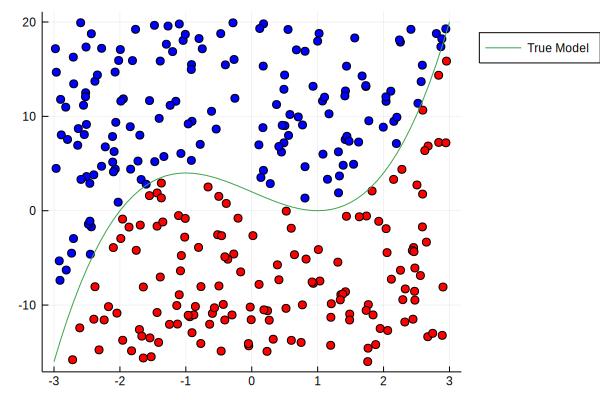

In [4]:
x1grid = -3:0.1:3
x2grid = -16:0.1:20

# Generate the inputs and corresponding outputs
input, output = generate_dataset(model, x1grid, x2grid, 300)

# Plot the data set
ishigher = vec(output .== 1)
function plot_data()
    scatter(input[1, ishigher], input[2, ishigher], label="", color=:blue)
    scatter!(input[1, .!ishigher], input[2, .!ishigher], label="", color=:red)
    plot!(x1grid, model.(x1grid), label="True Model", legend=:outertopright)
end
plot_data()

Below is the code for a general neural network architecture.

In [5]:
### Layer struct
struct Layer
    W # weight
    b # bias
    σ # activation function
    z::Ref{AbstractArray} # intermediate state
end

# Layer constructor: takes in the dimensions of the input and the output, as well as an activation function
Layer(in::Int, out::Int, σ::Function) = Layer(rand(out, in) .- 0.5, zeros(out), σ, [])

# Layer evaluation
function (l::Layer)(X)
    l.z[] = l.W * X .+ l.b # store intermediate state for back propagation
    return l.σ.(l.z[])
end

# Update layer given partial derivatives and learning rate
function update!(l::Layer, dW, db, η)
    l.W .-= η * dW
    l.b .-= η * db
end

# Back propagation given the input from the previous layer and the cost gradient wrt this layer's output
function back_propagate!(l::Layer, ∂Cost∂a_out, a_in, η)
    dσ = derive(l.σ)

    # Cost with respect to z
    ∂Cost∂z = ∂Cost∂a_out .* dσ.(l.z[])

    # Cost with respect to W
    ∂Cost∂W = sum([∂Cost∂z[:, i] * a_in[:, i]' for i in size(∂Cost∂z, 2)])

    # Cost with respect to b
    ∂Cost∂b = ∂Cost∂z * ones(size(∂Cost∂z, 2))

    # Update parameters
    update!(l, ∂Cost∂W, ∂Cost∂b, η)

    # Cost with respect to input from last layer
    ∂Cost∂a_in = l.W' * ∂Cost∂z
end

### Model struct
struct Model
    layers
    a::Ref{AbstractArray} # layer outputs

    # Model constructor
    Model(layers...) = new(layers, [])
end

# Model evaluation
function (m::Model)(X)
    m.a[] = [X]
    # Evaluate each layer and store their outputs
    for layer in m.layers
        push!(m.a[], layer(m.a[][end]))
    end
    # Return final output
    return m.a[][end]
end

# Model back propagation
function back_propagate!(m::Model, Cost, Y, η)
    # Calculate cost
    aL = pop!(m.a[]) # last output
    cost = Cost(aL, Y)
    ∂Cost∂aL = derive(Cost)(aL, Y) # gradient wrt aL

    # Back propagate through each layer
    ∂Cost∂a = ∂Cost∂aL
    for layer in reverse(m.layers)
        a_in = pop!(m.a[])
        ∂Cost∂a = back_propagate!(layer, ∂Cost∂a, a_in, η)
    end

    return cost
end

# Train model with a Cost objective, dataset, and learning rate
function train!(m::Model, Cost, dataset, η)
    costs = Float64[]

    for batch in dataset
        X, Y = batch
        # Forward pass
        output = m(X)
        # Back propagation
        cost = back_propagate!(m, Cost, Y, η)
        push!(costs, cost)
    end

    return sum(costs) / length(dataset)
end

train! (generic function with 1 method)

Let's build our neural network!

In [6]:
### Sigmoid activation function
sigmoid(x) = 1 / (1 + exp(-x))
derive(::typeof(sigmoid)) = x -> sigmoid(x) * (1 - sigmoid(x))

### Relu activation function
relu(x) = max(0, x)
derive(::typeof(relu)) = x -> (x ≥ 0 ? 1 : 0)

### Set up model
neural_model = Model(
    Layer(2, 10, relu),
    Layer(10, 1, sigmoid))

### Cost objective
# Binary cross entropy loss
bcentropy(ŷ, y) = -y * log(ŷ + 1e-7) - (1 - y) * log(1 - ŷ + 1e-7)
derive(::typeof(bcentropy)) = (ŷ, y) -> -y / ŷ + (1 - y) / (1 - ŷ)
# Cost function
Cost(Ŷ, Y) = sum(bcentropy.(Ŷ, Y)) / size(Y, 2)
derive(::typeof(Cost)) = (Ŷ, Y) -> derive(bcentropy).(Ŷ, Y) / size(Y, 2)

### Minibatching
function minibatch(input, output, batch_size)
    @assert size(input, 2) == size(output, 2) "Numbers of input and output doesn't match."
    inputs = Array[]
    outputs = Array[]

    rand_idxs = Random.randperm(size(input, 2))
    batch_idxs = Iterators.partition(rand_idxs, batch_size)
    for batch_idx in batch_idxs
        push!(inputs, input[:, batch_idx])
        push!(outputs, output[:, batch_idx])
    end

    zip(inputs, outputs) |> collect
end

### Model visualization
function plot_model(neural_model, x1grid, x2grid)
    plot_data()
    bound = fill(maximum(x2grid), size(x1grid))

    # Classify each point
    for (i, x1) in enumerate(x1grid)
        for x2 in x2grid
            out = neural_model([x1, x2])[1]
            if out ≥ 0.5
                bound[i] = x2
                break
            end
         end
    end

    plot!(x1grid, bound, label="Neural Network Model")
end

plot_model (generic function with 1 method)

Finally, train our model on the generated data set

In [7]:
η = 0.01 # learning rate
max_epoch = 2000 # maximum iteration
anim = Animation() # visualization

### Training loop
for i in 1:max_epoch
    dataset = minibatch(input, output, 5)

    # Train model
    cost = train!(neural_model, Cost, dataset, η)

    # Report loss
    println("Epoch $i cost: $cost")

    # Update visualization
    plot_model(neural_model, x1grid, x2grid)
    frame(anim)
end

Epoch 1 cost: 0.4926723587635671


Epoch 2 cost: 0.3489956210637208


Epoch 3 cost: 0.3114974827971079


Epoch 4 cost: 0.2885409098048912


Epoch 5 cost: 0.27879031268505544


Epoch 6 cost: 0.2745030257257012


Epoch 7 cost: 0.26661206421700767


Epoch 8 cost: 0.2611280282471438


Epoch 9 cost: 0.2589685836928885


Epoch 10 cost: 0.2561170536087659


Epoch 11 cost: 0.25351659540953314


Epoch 12 cost: 0.25175999961511164


Epoch 13 cost: 0.25275070924683696


Epoch 14 cost: 0.24980979738981285


Epoch 15 cost: 0.24838090954417746


Epoch 16 cost: 0.24711392864666398


Epoch 17 cost: 0.2422399273086831


Epoch 18 cost: 0.24172708406548624


Epoch 19 cost: 0.2408596747511252


Epoch 20 cost: 0.23893840164868005


Epoch 21 cost: 0.2393214724122856


Epoch 22 cost: 0.23689527814114214


Epoch 23 cost: 0.23651791185869436


Epoch 24 cost: 0.23579466874749055


Epoch 25 cost: 0.23370678657661298


Epoch 26 cost: 0.23260454374367978


Epoch 27 cost: 0.23080907850820365


Epoch 28 cost: 0.23022634306999554


Epoch 29 cost: 0.22946601497469832


Epoch 30 cost: 0.22918018254524955


Epoch 31 cost: 0.22735540903010718


Epoch 32 cost: 0.22719286836562932


Epoch 33 cost: 0.22568822371694466


Epoch 34 cost: 0.2241504759377763


Epoch 35 cost: 0.2225848684593154


Epoch 36 cost: 0.22151191148145613


Epoch 37 cost: 0.22235038411812963


Epoch 38 cost: 0.22108748964209138


Epoch 39 cost: 0.22080012786386563


Epoch 40 cost: 0.21889479173806203


Epoch 41 cost: 0.21977670243448286


Epoch 42 cost: 0.21850788326284892


Epoch 43 cost: 0.21849199996165886


Epoch 44 cost: 0.21600626162698508


Epoch 45 cost: 0.21494541105088796


Epoch 46 cost: 0.2158555344223586


Epoch 47 cost: 0.21321240495659508


Epoch 48 cost: 0.2132205000730856


Epoch 49 cost: 0.21382338264185555


Epoch 50 cost: 0.21116787893456643


Epoch 51 cost: 0.21226622614166443


Epoch 52 cost: 0.21237410564416842


Epoch 53 cost: 0.21086654338895894


Epoch 54 cost: 0.21125876650926612


Epoch 55 cost: 0.20864737277791243


Epoch 56 cost: 0.20963192251222149


Epoch 57 cost: 0.20909122821257867


Epoch 58 cost: 0.20880883425748958


Epoch 59 cost: 0.20712074994065494


Epoch 60 cost: 0.20665000325084953


Epoch 61 cost: 0.20726058053937818


Epoch 62 cost: 0.20589215974748235


Epoch 63 cost: 0.20605829469178746


Epoch 64 cost: 0.2078959844280565


Epoch 65 cost: 0.2072142777796478


Epoch 66 cost: 0.2073125365256497


Epoch 67 cost: 0.2062583768722688


Epoch 68 cost: 0.2055221263052607


Epoch 69 cost: 0.20350498152080634


Epoch 70 cost: 0.20370705652773174


Epoch 71 cost: 0.2026938317777745


Epoch 72 cost: 0.20511664514239578


Epoch 73 cost: 0.20419870465416867


Epoch 74 cost: 0.2048645908915927


Epoch 75 cost: 0.2040961214751694


Epoch 76 cost: 0.20482995108611932


Epoch 77 cost: 0.20490170097971416


Epoch 78 cost: 0.2046360736999705


Epoch 79 cost: 0.203769875521819


Epoch 80 cost: 0.2029476435140041


Epoch 81 cost: 0.20408953094374693


Epoch 82 cost: 0.2019255648879694


Epoch 83 cost: 0.19894577317715242


Epoch 84 cost: 0.19636589611554336


Epoch 85 cost: 0.19770524978980847


Epoch 86 cost: 0.19869155525656826


Epoch 87 cost: 0.19871295464187722


Epoch 88 cost: 0.19450664737047266


Epoch 89 cost: 0.19551134251520377


Epoch 90 cost: 0.19455728190269791


Epoch 91 cost: 0.19430119983240765


Epoch 92 cost: 0.19341111617758827


Epoch 93 cost: 0.19202987556903536


Epoch 94 cost: 0.1912755750596924


Epoch 95 cost: 0.19211147498061065


Epoch 96 cost: 0.1924100016747844


Epoch 97 cost: 0.1924939467607659


Epoch 98 cost: 0.1929261453715548


Epoch 99 cost: 0.1909257805085616


Epoch 100 cost: 0.19208831334017268


Epoch 101 cost: 0.19134991500742185


Epoch 102 cost: 0.1915712518629114


Epoch 103 cost: 0.193331295230408


Epoch 104 cost: 0.1904361079078739


Epoch 105 cost: 0.19098910475935763


Epoch 106 cost: 0.1893534540984162


Epoch 107 cost: 0.19031026468639572


Epoch 108 cost: 0.1909647044313284


Epoch 109 cost: 0.1884400847564221


Epoch 110 cost: 0.18888351060041547


Epoch 111 cost: 0.18786536067763676


Epoch 112 cost: 0.18733523597135807


Epoch 113 cost: 0.1872481709420469


Epoch 114 cost: 0.1855897297736128


Epoch 115 cost: 0.18747065748339223


Epoch 116 cost: 0.18627497079760172


Epoch 117 cost: 0.1861116724017518


Epoch 118 cost: 0.18552444524062708


Epoch 119 cost: 0.18582566772533995


Epoch 120 cost: 0.18486180106150024


Epoch 121 cost: 0.1854974427474953


Epoch 122 cost: 0.18451786311595111


Epoch 123 cost: 0.18479699376826855


Epoch 124 cost: 0.18440074107344004


Epoch 125 cost: 0.18444152017610194


Epoch 126 cost: 0.18416858632449384


Epoch 127 cost: 0.18541343775044422


Epoch 128 cost: 0.18537329022434382


Epoch 129 cost: 0.18485264854746702


Epoch 130 cost: 0.18581641296477036


Epoch 131 cost: 0.18709743439938284


Epoch 132 cost: 0.1833255970633353


Epoch 133 cost: 0.18591209486307983


Epoch 134 cost: 0.1841284413362034


Epoch 135 cost: 0.18410253368782822


Epoch 136 cost: 0.18329664566133094


Epoch 137 cost: 0.18295724451068404


Epoch 138 cost: 0.18266870956202297


Epoch 139 cost: 0.1832241877470115


Epoch 140 cost: 0.1837315047784844


Epoch 141 cost: 0.18581106261016628


Epoch 142 cost: 0.18271963532382765


Epoch 143 cost: 0.1804031893602744


Epoch 144 cost: 0.18150004421113436


Epoch 145 cost: 0.18120904835256188


Epoch 146 cost: 0.18182791224341563


Epoch 147 cost: 0.18377483300649633


Epoch 148 cost: 0.18251909962912327


Epoch 149 cost: 0.18264456940797744


Epoch 150 cost: 0.182407833742714


Epoch 151 cost: 0.18398443546368395


Epoch 152 cost: 0.18455580857206197


Epoch 153 cost: 0.18504455132091674


Epoch 154 cost: 0.18562349297280706


Epoch 155 cost: 0.1869938851849019


Epoch 156 cost: 0.18280252816944648


Epoch 157 cost: 0.18170205952861557


Epoch 158 cost: 0.18206262951212923


Epoch 159 cost: 0.1816311966865848


Epoch 160 cost: 0.18024653270268792


Epoch 161 cost: 0.17916636272805744


Epoch 162 cost: 0.17907311662906997


Epoch 163 cost: 0.17875723979815333


Epoch 164 cost: 0.18165064596304645


Epoch 165 cost: 0.17680043973425857


Epoch 166 cost: 0.17979810691440926


Epoch 167 cost: 0.18062540814420994


Epoch 168 cost: 0.18060877765289204


Epoch 169 cost: 0.17841947294309612


Epoch 170 cost: 0.17700259541395788


Epoch 171 cost: 0.17815280301749736


Epoch 172 cost: 0.1765548203722869


Epoch 173 cost: 0.1772013861949229


Epoch 174 cost: 0.17697450255225985


Epoch 175 cost: 0.17703006681351158


Epoch 176 cost: 0.17798633987890533


Epoch 177 cost: 0.17764568261604713


Epoch 178 cost: 0.1759347357970741


Epoch 179 cost: 0.1758544258081401


Epoch 180 cost: 0.17901789980481722


Epoch 181 cost: 0.17636202601137627


Epoch 182 cost: 0.17591853985307168


Epoch 183 cost: 0.1744796068022172


Epoch 184 cost: 0.17527955256209035


Epoch 185 cost: 0.1742229995380685


Epoch 186 cost: 0.17494027259246797


Epoch 187 cost: 0.17510815145681982


Epoch 188 cost: 0.1749976926316799


Epoch 189 cost: 0.17578532165115873


Epoch 190 cost: 0.1741444520869432


Epoch 191 cost: 0.17390313813743452


Epoch 192 cost: 0.17574857402358066


Epoch 193 cost: 0.1746722485577132


Epoch 194 cost: 0.17389318312392701


Epoch 195 cost: 0.1746141863405315


Epoch 196 cost: 0.17562232303109407


Epoch 197 cost: 0.17355188116052567


Epoch 198 cost: 0.1739700765813822


Epoch 199 cost: 0.17547906493785528


Epoch 200 cost: 0.17560608110418477


Epoch 201 cost: 0.17356338133000093


Epoch 202 cost: 0.17333443237253873


Epoch 203 cost: 0.17418839963934937


Epoch 204 cost: 0.17250369679326563


Epoch 205 cost: 0.17381219484504026


Epoch 206 cost: 0.1717651027177328


Epoch 207 cost: 0.17313966827037133


Epoch 208 cost: 0.1718589414404865


Epoch 209 cost: 0.17209036005015046


Epoch 210 cost: 0.172441598862135


Epoch 211 cost: 0.17392979725717614


Epoch 212 cost: 0.17451743568405967


Epoch 213 cost: 0.17459742616585255


Epoch 214 cost: 0.1747937357776529


Epoch 215 cost: 0.17444027425582084


Epoch 216 cost: 0.1730727138141827


Epoch 217 cost: 0.17169394272524247


Epoch 218 cost: 0.1701646428000238


Epoch 219 cost: 0.16965217751326825


Epoch 220 cost: 0.17121839014937618


Epoch 221 cost: 0.1695063070330494


Epoch 222 cost: 0.17062991474340589


Epoch 223 cost: 0.17151338624595183


Epoch 224 cost: 0.17076585049050996


Epoch 225 cost: 0.16944959093224024


Epoch 226 cost: 0.17003741511718123


Epoch 227 cost: 0.1711129994032125


Epoch 228 cost: 0.16915472900357073


Epoch 229 cost: 0.17621461773164054


Epoch 230 cost: 0.17315085562238916


Epoch 231 cost: 0.1727215308909919


Epoch 232 cost: 0.17737396083492663


Epoch 233 cost: 0.17915737163037196


Epoch 234 cost: 0.17007389224197514


Epoch 235 cost: 0.1688028274865508


Epoch 236 cost: 0.16710003008026356


Epoch 237 cost: 0.16893258556750698


Epoch 238 cost: 0.16783727860033723


Epoch 239 cost: 0.16974315624456743


Epoch 240 cost: 0.16727620644854974


Epoch 241 cost: 0.16778910601281213


Epoch 242 cost: 0.1666122147199983


Epoch 243 cost: 0.1691020564149681


Epoch 244 cost: 0.16771650385441325


Epoch 245 cost: 0.1654669020761593


Epoch 246 cost: 0.16710183640772017


Epoch 247 cost: 0.16880111289746605


Epoch 248 cost: 0.1672587488766912


Epoch 249 cost: 0.16824714487255008


Epoch 250 cost: 0.16837470229505075


Epoch 251 cost: 0.1682471354246369


Epoch 252 cost: 0.1658936379402975


Epoch 253 cost: 0.1672720220686724


Epoch 254 cost: 0.16744976934608993


Epoch 255 cost: 0.16831165965334122


Epoch 256 cost: 0.16663370261187266


Epoch 257 cost: 0.16715079777625613


Epoch 258 cost: 0.17025152392920073


Epoch 259 cost: 0.171197235925273


Epoch 260 cost: 0.16686732480730665


Epoch 261 cost: 0.1672944110445062


Epoch 262 cost: 0.16633465937953146


Epoch 263 cost: 0.16575188653301692


Epoch 264 cost: 0.16510421729978642


Epoch 265 cost: 0.16576357584755047


Epoch 266 cost: 0.16555968561068435


Epoch 267 cost: 0.1645965191025093


Epoch 268 cost: 0.16520739734723494


Epoch 269 cost: 0.16539900251454867


Epoch 270 cost: 0.16473775201367424


Epoch 271 cost: 0.16488972292929782


Epoch 272 cost: 0.16679822377508918


Epoch 273 cost: 0.16604684801606212


Epoch 274 cost: 0.16978150022725322


Epoch 275 cost: 0.1710721545042264


Epoch 276 cost: 0.16853825961740915


Epoch 277 cost: 0.16634846101692483


Epoch 278 cost: 0.16690102713682067


Epoch 279 cost: 0.16583670975882506


Epoch 280 cost: 0.16527554475483722


Epoch 281 cost: 0.16436639257002977


Epoch 282 cost: 0.16504737764615734


Epoch 283 cost: 0.1659101109262258


Epoch 284 cost: 0.1631901751306925


Epoch 285 cost: 0.16525961090569413


Epoch 286 cost: 0.16594285875303383


Epoch 287 cost: 0.16492761050780683


Epoch 288 cost: 0.1643758000330065


Epoch 289 cost: 0.16750042952124994


Epoch 290 cost: 0.16534964423597023


Epoch 291 cost: 0.1713943534614934


Epoch 292 cost: 0.1658857224624634


Epoch 293 cost: 0.1624758482315927


Epoch 294 cost: 0.1624987006162563


Epoch 295 cost: 0.16327677096558102


Epoch 296 cost: 0.1688910466795461


Epoch 297 cost: 0.1632622964412485


Epoch 298 cost: 0.16319421881309001


Epoch 299 cost: 0.16046420523073807


Epoch 300 cost: 0.1615083036329974


Epoch 301 cost: 0.16343614145500182


Epoch 302 cost: 0.16356869738527086


Epoch 303 cost: 0.16341158641271375


Epoch 304 cost: 0.1633771720531167


Epoch 305 cost: 0.16252195322245205


Epoch 306 cost: 0.16213802887367892


Epoch 307 cost: 0.16426887610450783


Epoch 308 cost: 0.16112557196457342


Epoch 309 cost: 0.16192613257661773


Epoch 310 cost: 0.16120108324960397


Epoch 311 cost: 0.1637529166324287


Epoch 312 cost: 0.16364672902820057


Epoch 313 cost: 0.16271006184756195


Epoch 314 cost: 0.1623661098882214


Epoch 315 cost: 0.1605764672612761


Epoch 316 cost: 0.1615723043924238


Epoch 317 cost: 0.1627075589544729


Epoch 318 cost: 0.16022849790957214


Epoch 319 cost: 0.16009345460425617


Epoch 320 cost: 0.16126287572376904


Epoch 321 cost: 0.15921536180542228


Epoch 322 cost: 0.15973422869365503


Epoch 323 cost: 0.16130722885248794


Epoch 324 cost: 0.16154816398871155


Epoch 325 cost: 0.16030974361807923


Epoch 326 cost: 0.16264346434043142


Epoch 327 cost: 0.1609670455735931


Epoch 328 cost: 0.16350370516310653


Epoch 329 cost: 0.16267904841380007


Epoch 330 cost: 0.1646447582895896


Epoch 331 cost: 0.16676596173486932


Epoch 332 cost: 0.16091345706314422


Epoch 333 cost: 0.16042539797990427


Epoch 334 cost: 0.1603512382572626


Epoch 335 cost: 0.15891470189164592


Epoch 336 cost: 0.15924017556934528


Epoch 337 cost: 0.1587166745476525


Epoch 338 cost: 0.15866901509358075


Epoch 339 cost: 0.15875895790386693


Epoch 340 cost: 0.1621757814335995


Epoch 341 cost: 0.1630174107745425


Epoch 342 cost: 0.1621339336527239


Epoch 343 cost: 0.16302497952303738


Epoch 344 cost: 0.1582495109175447


Epoch 345 cost: 0.15832014141639125


Epoch 346 cost: 0.15978256229142887


Epoch 347 cost: 0.1591439876924619


Epoch 348 cost: 0.15928792812870854


Epoch 349 cost: 0.16281075350554747


Epoch 350 cost: 0.15961947899777815


Epoch 351 cost: 0.16061586989907334


Epoch 352 cost: 0.15924322090440557


Epoch 353 cost: 0.15788103465975337


Epoch 354 cost: 0.15884332626191364


Epoch 355 cost: 0.16029661305147383


Epoch 356 cost: 0.15858527236561112


Epoch 357 cost: 0.15862791177789906


Epoch 358 cost: 0.1596002525876701


Epoch 359 cost: 0.16011038863733146


Epoch 360 cost: 0.1606696905444342


Epoch 361 cost: 0.16141500068438563


Epoch 362 cost: 0.16135578954314758


Epoch 363 cost: 0.15945356526066026


Epoch 364 cost: 0.16013252703211017


Epoch 365 cost: 0.15985181873130738


Epoch 366 cost: 0.16040579164706575


Epoch 367 cost: 0.15989609074598693


Epoch 368 cost: 0.1586249625840266


Epoch 369 cost: 0.1598747111159821


Epoch 370 cost: 0.1599909838844405


Epoch 371 cost: 0.1605205593269405


Epoch 372 cost: 0.16294880149354707


Epoch 373 cost: 0.15614645820336223


Epoch 374 cost: 0.15771861302612172


Epoch 375 cost: 0.15938784158467784


Epoch 376 cost: 0.1568608851199693


Epoch 377 cost: 0.15897490900476202


Epoch 378 cost: 0.16034680069893698


Epoch 379 cost: 0.15807851048859428


Epoch 380 cost: 0.1607635472187265


Epoch 381 cost: 0.1631264828771855


Epoch 382 cost: 0.15703568513426452


Epoch 383 cost: 0.15633442446157525


Epoch 384 cost: 0.1557793311877236


Epoch 385 cost: 0.1564263999624271


Epoch 386 cost: 0.15663980976975592


Epoch 387 cost: 0.15631283827364326


Epoch 388 cost: 0.15784360721575327


Epoch 389 cost: 0.15680012946504557


Epoch 390 cost: 0.1560726141792596


Epoch 391 cost: 0.1562296248230152


Epoch 392 cost: 0.1580755758973336


Epoch 393 cost: 0.15603755371111985


Epoch 394 cost: 0.15837701502698925


Epoch 395 cost: 0.1561480238589413


Epoch 396 cost: 0.1546724522989445


Epoch 397 cost: 0.1545166980666955


Epoch 398 cost: 0.15483072272163864


Epoch 399 cost: 0.15464057224393438


Epoch 400 cost: 0.15503459621324683


Epoch 401 cost: 0.15543744476430335


Epoch 402 cost: 0.15640471331346534


Epoch 403 cost: 0.15661049198654


Epoch 404 cost: 0.15661642521828892


Epoch 405 cost: 0.15905718623144835


Epoch 406 cost: 0.1552896982254512


Epoch 407 cost: 0.1557126927578582


Epoch 408 cost: 0.1555832393675027


Epoch 409 cost: 0.1562573808289553


Epoch 410 cost: 0.15749966987163333


Epoch 411 cost: 0.15549023813749505


Epoch 412 cost: 0.15844974075766202


Epoch 413 cost: 0.15984112738982795


Epoch 414 cost: 0.1631838840660612


Epoch 415 cost: 0.16738875747689236


Epoch 416 cost: 0.15867072153093073


Epoch 417 cost: 0.15827837998994226


Epoch 418 cost: 0.1593149167993153


Epoch 419 cost: 0.15464031003079226


Epoch 420 cost: 0.1532504164668801


Epoch 421 cost: 0.15212253529049402


Epoch 422 cost: 0.15633771666420504


Epoch 423 cost: 0.1528574192703488


Epoch 424 cost: 0.15378838279501045


Epoch 425 cost: 0.15358641670986903


Epoch 426 cost: 0.1531574489306127


Epoch 427 cost: 0.1530154590017085


Epoch 428 cost: 0.152332978055596


Epoch 429 cost: 0.1554119909875017


Epoch 430 cost: 0.1532401596950549


Epoch 431 cost: 0.15246564297855064


Epoch 432 cost: 0.15447809364771486


Epoch 433 cost: 0.15292446892300351


Epoch 434 cost: 0.1533649240930732


Epoch 435 cost: 0.1541112826618956


Epoch 436 cost: 0.15111734644288716


Epoch 437 cost: 0.15060917846338776


Epoch 438 cost: 0.15168806066837942


Epoch 439 cost: 0.15220041102657664


Epoch 440 cost: 0.15223537388204425


Epoch 441 cost: 0.15149978163552139


Epoch 442 cost: 0.15307232898722586


Epoch 443 cost: 0.15111914497576173


Epoch 444 cost: 0.15234789893092499


Epoch 445 cost: 0.14920524019340287


Epoch 446 cost: 0.15419228468811988


Epoch 447 cost: 0.15482488770787556


Epoch 448 cost: 0.15212774988360914


Epoch 449 cost: 0.15298125027287218


Epoch 450 cost: 0.15195060585473705


Epoch 451 cost: 0.1529191192713964


Epoch 452 cost: 0.15453741586276223


Epoch 453 cost: 0.15250970552577175


Epoch 454 cost: 0.15134640975211777


Epoch 455 cost: 0.1546703223718681


Epoch 456 cost: 0.15723579313584676


Epoch 457 cost: 0.1523407402429787


Epoch 458 cost: 0.15078750831270002


Epoch 459 cost: 0.15112754314020246


Epoch 460 cost: 0.15037305074987423


Epoch 461 cost: 0.14990045405065933


Epoch 462 cost: 0.15071013874674102


Epoch 463 cost: 0.14981589944564816


Epoch 464 cost: 0.15198281411281878


Epoch 465 cost: 0.15424500429337448


Epoch 466 cost: 0.15053086947698896


Epoch 467 cost: 0.1510158058067968


Epoch 468 cost: 0.15133473012327378


Epoch 469 cost: 0.1513638425604837


Epoch 470 cost: 0.14938335864282962


Epoch 471 cost: 0.1500216967717995


Epoch 472 cost: 0.1486077446555211


Epoch 473 cost: 0.1478356255153686


Epoch 474 cost: 0.14922738291130339


Epoch 475 cost: 0.15233034434230186


Epoch 476 cost: 0.1499626281605644


Epoch 477 cost: 0.14857423094964944


Epoch 478 cost: 0.147094179061587


Epoch 479 cost: 0.14776296424313295


Epoch 480 cost: 0.15284118233160907


Epoch 481 cost: 0.14939514352786906


Epoch 482 cost: 0.14643354526501995


Epoch 483 cost: 0.1472667893050129


Epoch 484 cost: 0.14822937569597439


Epoch 485 cost: 0.14725443367922442


Epoch 486 cost: 0.1486301504537525


Epoch 487 cost: 0.1491509381826156


Epoch 488 cost: 0.14760208036728678


Epoch 489 cost: 0.147641868043134


Epoch 490 cost: 0.14802797288801334


Epoch 491 cost: 0.14795126105185533


Epoch 492 cost: 0.1491316588157875


Epoch 493 cost: 0.14790564436053977


Epoch 494 cost: 0.15002221626016357


Epoch 495 cost: 0.14847614604273485


Epoch 496 cost: 0.14808855833655502


Epoch 497 cost: 0.14740524745224654


Epoch 498 cost: 0.14867678659430814


Epoch 499 cost: 0.15120320920295327


Epoch 500 cost: 0.14889565257515752


Epoch 501 cost: 0.14751608567340105


Epoch 502 cost: 0.1490891299779835


Epoch 503 cost: 0.14746885011134328


Epoch 504 cost: 0.14665976586751703


Epoch 505 cost: 0.14672855857385853


Epoch 506 cost: 0.14790200903449857


Epoch 507 cost: 0.1483149159087139


Epoch 508 cost: 0.151724756594966


Epoch 509 cost: 0.14933461210036716


Epoch 510 cost: 0.14592766906288912


Epoch 511 cost: 0.1465666047006358


Epoch 512 cost: 0.14823256503520504


Epoch 513 cost: 0.15031954742318915


Epoch 514 cost: 0.14830837017644308


Epoch 515 cost: 0.14777102743596354


Epoch 516 cost: 0.1501834404974026


Epoch 517 cost: 0.14824487478807366


Epoch 518 cost: 0.14607838212882


Epoch 519 cost: 0.1442412153853968


Epoch 520 cost: 0.1444202420302094


Epoch 521 cost: 0.15204544353694396


Epoch 522 cost: 0.1468308124890737


Epoch 523 cost: 0.14506808175440478


Epoch 524 cost: 0.14692391519718895


Epoch 525 cost: 0.14374481795122807


Epoch 526 cost: 0.14569319404114336


Epoch 527 cost: 0.14660578965759932


Epoch 528 cost: 0.14609592837462354


Epoch 529 cost: 0.1452867569731143


Epoch 530 cost: 0.1440502644539884


Epoch 531 cost: 0.145821981117698


Epoch 532 cost: 0.14441320531280857


Epoch 533 cost: 0.14393577258841528


Epoch 534 cost: 0.14430298135391514


Epoch 535 cost: 0.14716591106041482


Epoch 536 cost: 0.14802676101584533


Epoch 537 cost: 0.14940968259180482


Epoch 538 cost: 0.14678337510137265


Epoch 539 cost: 0.15212512538426057


Epoch 540 cost: 0.14824657107087277


Epoch 541 cost: 0.1449891579865422


Epoch 542 cost: 0.14523712235490446


Epoch 543 cost: 0.1425163346236238


Epoch 544 cost: 0.14294521449576855


Epoch 545 cost: 0.14356050964376993


Epoch 546 cost: 0.14328104348621923


Epoch 547 cost: 0.14355644468626025


Epoch 548 cost: 0.1430841754293344


Epoch 549 cost: 0.14358180882445173


Epoch 550 cost: 0.14550028590312464


Epoch 551 cost: 0.1431513622061192


Epoch 552 cost: 0.14246543308634066


Epoch 553 cost: 0.14690498391275691


Epoch 554 cost: 0.1436252190689205


Epoch 555 cost: 0.14347830444382811


Epoch 556 cost: 0.13923022693798717


Epoch 557 cost: 0.1424771223863579


Epoch 558 cost: 0.14161487106432263


Epoch 559 cost: 0.14206961862378217


Epoch 560 cost: 0.14343116157136976


Epoch 561 cost: 0.14192813335093613


Epoch 562 cost: 0.14229335014735056


Epoch 563 cost: 0.14340042986663507


Epoch 564 cost: 0.1448444134458022


Epoch 565 cost: 0.1431757142029108


Epoch 566 cost: 0.14520330596185774


Epoch 567 cost: 0.14702314311363196


Epoch 568 cost: 0.14037518516244268


Epoch 569 cost: 0.1402870296684443


Epoch 570 cost: 0.14193860421408594


Epoch 571 cost: 0.14111456340229425


Epoch 572 cost: 0.1404618282907889


Epoch 573 cost: 0.1430784651892294


Epoch 574 cost: 0.14381435494203684


Epoch 575 cost: 0.14263095811081622


Epoch 576 cost: 0.14187642179910762


Epoch 577 cost: 0.13952085376708317


Epoch 578 cost: 0.14274802576805


Epoch 579 cost: 0.14250677009663495


Epoch 580 cost: 0.14175074265136903


Epoch 581 cost: 0.14125349484409902


Epoch 582 cost: 0.13970436941905662


Epoch 583 cost: 0.1402062754792806


Epoch 584 cost: 0.14006148137839744


Epoch 585 cost: 0.14079529435983065


Epoch 586 cost: 0.1427996838792103


Epoch 587 cost: 0.1431048291675595


Epoch 588 cost: 0.14221379530983227


Epoch 589 cost: 0.14384957224228997


Epoch 590 cost: 0.1425593925291045


Epoch 591 cost: 0.14207660240796066


Epoch 592 cost: 0.1449050987128732


Epoch 593 cost: 0.14101161436170043


Epoch 594 cost: 0.1407626955259398


Epoch 595 cost: 0.14053896122767776


Epoch 596 cost: 0.14320878507746776


Epoch 597 cost: 0.14117045934893463


Epoch 598 cost: 0.14153643005415853


Epoch 599 cost: 0.1412519018380514


Epoch 600 cost: 0.14327461665359603


Epoch 601 cost: 0.14103110088274884


Epoch 602 cost: 0.14029866846155684


Epoch 603 cost: 0.13996133772437133


Epoch 604 cost: 0.14244358316972988


Epoch 605 cost: 0.14295865491060872


Epoch 606 cost: 0.14413401147044036


Epoch 607 cost: 0.14479543473866327


Epoch 608 cost: 0.13961522906920248


Epoch 609 cost: 0.14549712395525158


Epoch 610 cost: 0.14654647357505626


Epoch 611 cost: 0.1398600102387018


Epoch 612 cost: 0.1373477730954267


Epoch 613 cost: 0.13749437971591102


Epoch 614 cost: 0.13731109716040235


Epoch 615 cost: 0.14011780644051758


Epoch 616 cost: 0.1383501382927071


Epoch 617 cost: 0.1392783824807479


Epoch 618 cost: 0.13802175288852492


Epoch 619 cost: 0.13781133282166172


Epoch 620 cost: 0.13668060354022354


Epoch 621 cost: 0.13726357104183784


Epoch 622 cost: 0.13712254848903546


Epoch 623 cost: 0.13749207276003456


Epoch 624 cost: 0.13860295840285805


Epoch 625 cost: 0.14620034219513445


Epoch 626 cost: 0.14085788908557928


Epoch 627 cost: 0.14386292227618344


Epoch 628 cost: 0.14106651711461163


Epoch 629 cost: 0.1344098421445979


Epoch 630 cost: 0.1369299155488582


Epoch 631 cost: 0.1375014665746737


Epoch 632 cost: 0.1356807340204503


Epoch 633 cost: 0.13682821580281723


Epoch 634 cost: 0.13479253462843593


Epoch 635 cost: 0.14025043249959498


Epoch 636 cost: 0.13517346418273535


Epoch 637 cost: 0.13707304922777594


Epoch 638 cost: 0.13514182313625253


Epoch 639 cost: 0.13519995408288202


Epoch 640 cost: 0.13498894420550986


Epoch 641 cost: 0.13579719151482614


Epoch 642 cost: 0.13566633032699874


Epoch 643 cost: 0.1348960217667962


Epoch 644 cost: 0.13882403888928416


Epoch 645 cost: 0.13348009488993232


Epoch 646 cost: 0.13320984521043885


Epoch 647 cost: 0.13107961460843584


Epoch 648 cost: 0.13525363953891154


Epoch 649 cost: 0.13675013970486224


Epoch 650 cost: 0.13828677459441177


Epoch 651 cost: 0.13344185799537378


Epoch 652 cost: 0.13947590034405935


Epoch 653 cost: 0.13404735437506204


Epoch 654 cost: 0.13822876293951128


Epoch 655 cost: 0.14062632923493082


Epoch 656 cost: 0.1335777082871445


Epoch 657 cost: 0.13154932529635383


Epoch 658 cost: 0.13299262000665105


Epoch 659 cost: 0.13297592654397888


Epoch 660 cost: 0.13550300095018258


Epoch 661 cost: 0.13789894024341967


Epoch 662 cost: 0.13395492451778448


Epoch 663 cost: 0.13309891264500268


Epoch 664 cost: 0.13354216438019267


Epoch 665 cost: 0.1346931320801504


Epoch 666 cost: 0.1356624538932457


Epoch 667 cost: 0.1366818336949723


Epoch 668 cost: 0.13257706899079538


Epoch 669 cost: 0.13385167224061423


Epoch 670 cost: 0.13500398686437073


Epoch 671 cost: 0.13476244699455667


Epoch 672 cost: 0.13185560704271196


Epoch 673 cost: 0.13563889124046338


Epoch 674 cost: 0.13737933510772782


Epoch 675 cost: 0.13991148332062545


Epoch 676 cost: 0.14185402836108668


Epoch 677 cost: 0.14218853429298114


Epoch 678 cost: 0.14030191942637368


Epoch 679 cost: 0.1337555331004207


Epoch 680 cost: 0.1328295287621945


Epoch 681 cost: 0.1344545011724518


Epoch 682 cost: 0.13149550637382879


Epoch 683 cost: 0.13393782900604065


Epoch 684 cost: 0.13615036102326847


Epoch 685 cost: 0.13871656786480055


Epoch 686 cost: 0.1376016289975207


Epoch 687 cost: 0.13757547186755847


Epoch 688 cost: 0.13951721984995


Epoch 689 cost: 0.1348281438209122


Epoch 690 cost: 0.13938875779277635


Epoch 691 cost: 0.1373422610171862


Epoch 692 cost: 0.13047513539699337


Epoch 693 cost: 0.13425590134098153


Epoch 694 cost: 0.13094032510686193


Epoch 695 cost: 0.13296980255886975


Epoch 696 cost: 0.130937959351498


Epoch 697 cost: 0.13020235848160353


Epoch 698 cost: 0.13192503113833473


Epoch 699 cost: 0.1296262522958289


Epoch 700 cost: 0.1301539800649622


Epoch 701 cost: 0.13095889676914033


Epoch 702 cost: 0.13086604465368337


Epoch 703 cost: 0.13217105851444086


Epoch 704 cost: 0.1310916052918338


Epoch 705 cost: 0.13035841268192586


Epoch 706 cost: 0.13233821562022


Epoch 707 cost: 0.13286562557163878


Epoch 708 cost: 0.13199950989696846


Epoch 709 cost: 0.1295302675691252


Epoch 710 cost: 0.13236221053831507


Epoch 711 cost: 0.13250277686292822


Epoch 712 cost: 0.13538503265600366


Epoch 713 cost: 0.13294166809812286


Epoch 714 cost: 0.1364934044435454


Epoch 715 cost: 0.13113511985380075


Epoch 716 cost: 0.1323483454204601


Epoch 717 cost: 0.1300726155031133


Epoch 718 cost: 0.12972417188641563


Epoch 719 cost: 0.13189542579685992


Epoch 720 cost: 0.12993472407060416


Epoch 721 cost: 0.12834981004111565


Epoch 722 cost: 0.1279393495927021


Epoch 723 cost: 0.1289953239264444


Epoch 724 cost: 0.13062397669695153


Epoch 725 cost: 0.1375563899110129


Epoch 726 cost: 0.13266571568058194


Epoch 727 cost: 0.1274812117928265


Epoch 728 cost: 0.12799004586527743


Epoch 729 cost: 0.13044930190964865


Epoch 730 cost: 0.12798793602320804


Epoch 731 cost: 0.12697389844017704


Epoch 732 cost: 0.12981837695333606


Epoch 733 cost: 0.13134848685452374


Epoch 734 cost: 0.1330242665837388


Epoch 735 cost: 0.12775084731930472


Epoch 736 cost: 0.1270235003997821


Epoch 737 cost: 0.13007724503736548


Epoch 738 cost: 0.13276686906293564


Epoch 739 cost: 0.13181503312199433


Epoch 740 cost: 0.1282052755176901


Epoch 741 cost: 0.1267096587260734


Epoch 742 cost: 0.13323760489835956


Epoch 743 cost: 0.15085232311918856


Epoch 744 cost: 0.1311158618881252


Epoch 745 cost: 0.12685198556859248


Epoch 746 cost: 0.126572486231903


Epoch 747 cost: 0.12676065357264282


Epoch 748 cost: 0.12457486784829098


Epoch 749 cost: 0.12480382217923411


Epoch 750 cost: 0.12614573367571275


Epoch 751 cost: 0.12347532352659511


Epoch 752 cost: 0.1301254762794677


Epoch 753 cost: 0.12551073945534408


Epoch 754 cost: 0.1265178853731612


Epoch 755 cost: 0.12760867448755722


Epoch 756 cost: 0.12815747613405176


Epoch 757 cost: 0.12630830227381443


Epoch 758 cost: 0.12391645610683423


Epoch 759 cost: 0.1292326871784623


Epoch 760 cost: 0.12927571269771257


Epoch 761 cost: 0.12917317938057848


Epoch 762 cost: 0.12437968192269513


Epoch 763 cost: 0.12396269047507151


Epoch 764 cost: 0.128931800704097


Epoch 765 cost: 0.12677422930492815


Epoch 766 cost: 0.12675393080346678


Epoch 767 cost: 0.125658772246395


Epoch 768 cost: 0.1261162554861166


Epoch 769 cost: 0.12401493137922873


Epoch 770 cost: 0.12236128807252468


Epoch 771 cost: 0.12581705684018532


Epoch 772 cost: 0.12360969785494727


Epoch 773 cost: 0.1267412650331795


Epoch 774 cost: 0.12977121565035316


Epoch 775 cost: 0.12646336637265596


Epoch 776 cost: 0.13526479566962848


Epoch 777 cost: 0.12279851779515359


Epoch 778 cost: 0.1224993647395687


Epoch 779 cost: 0.12131579097536513


Epoch 780 cost: 0.12512694212230402


Epoch 781 cost: 0.12391599726609509


Epoch 782 cost: 0.12494726126965094


Epoch 783 cost: 0.12280519286444155


Epoch 784 cost: 0.1244954771961286


Epoch 785 cost: 0.12203057488450128


Epoch 786 cost: 0.1262716686856404


Epoch 787 cost: 0.122975416982611


Epoch 788 cost: 0.12706913981939147


Epoch 789 cost: 0.121148768433067


Epoch 790 cost: 0.1227040553098064


Epoch 791 cost: 0.12268796701565009


Epoch 792 cost: 0.12362014696884722


Epoch 793 cost: 0.11946010802467187


Epoch 794 cost: 0.11863706262711612


Epoch 795 cost: 0.12072790576500465


Epoch 796 cost: 0.12317238295824014


Epoch 797 cost: 0.12055614596401334


Epoch 798 cost: 0.12552923053553866


Epoch 799 cost: 0.12068836623125324


Epoch 800 cost: 0.12073558933490666


Epoch 801 cost: 0.12571993293103798


Epoch 802 cost: 0.12370598541184179


Epoch 803 cost: 0.12509205530664425


Epoch 804 cost: 0.12225062427301843


Epoch 805 cost: 0.12186962667416731


Epoch 806 cost: 0.11941690854647906


Epoch 807 cost: 0.12133902674529086


Epoch 808 cost: 0.12008199471083841


Epoch 809 cost: 0.12184095761104796


Epoch 810 cost: 0.12239068394488745


Epoch 811 cost: 0.1212686523824524


Epoch 812 cost: 0.1256298277660294


Epoch 813 cost: 0.11961381658756304


Epoch 814 cost: 0.12318440229850373


Epoch 815 cost: 0.12272445097207331


Epoch 816 cost: 0.12342038495871173


Epoch 817 cost: 0.12351064377189819


Epoch 818 cost: 0.12647926450299526


Epoch 819 cost: 0.12149821286189853


Epoch 820 cost: 0.11871295574936915


Epoch 821 cost: 0.11948415857010285


Epoch 822 cost: 0.12025212447656325


Epoch 823 cost: 0.12241029301990526


Epoch 824 cost: 0.12562009151994952


Epoch 825 cost: 0.12709514278683526


Epoch 826 cost: 0.12077521506322036


Epoch 827 cost: 0.12241558007509355


Epoch 828 cost: 0.11777224135402338


Epoch 829 cost: 0.12042789161651743


Epoch 830 cost: 0.13179524271508486


Epoch 831 cost: 0.12002084650302798


Epoch 832 cost: 0.12222425073598941


Epoch 833 cost: 0.12190626045114626


Epoch 834 cost: 0.12156204158559596


Epoch 835 cost: 0.1206688669990768


Epoch 836 cost: 0.12011096774583789


Epoch 837 cost: 0.12518722874947696


Epoch 838 cost: 0.11645511161094226


Epoch 839 cost: 0.11588825979432792


Epoch 840 cost: 0.12145768612048354


Epoch 841 cost: 0.12208394473263601


Epoch 842 cost: 0.11937349888151931


Epoch 843 cost: 0.12096962373380159


Epoch 844 cost: 0.11865023698262285


Epoch 845 cost: 0.11936591153705747


Epoch 846 cost: 0.12173939355293215


Epoch 847 cost: 0.12333461322667906


Epoch 848 cost: 0.11797448462154278


Epoch 849 cost: 0.11559818920166756


Epoch 850 cost: 0.11541591714283941


Epoch 851 cost: 0.11624410237329387


Epoch 852 cost: 0.11845309091468065


Epoch 853 cost: 0.12237719311299429


Epoch 854 cost: 0.12436696415862601


Epoch 855 cost: 0.12283149948832008


Epoch 856 cost: 0.1245614788730835


Epoch 857 cost: 0.12690281102980616


Epoch 858 cost: 0.12694267136130657


Epoch 859 cost: 0.12734073439859114


Epoch 860 cost: 0.12851408485681295


Epoch 861 cost: 0.13234507924347247


Epoch 862 cost: 0.12744982741627353


Epoch 863 cost: 0.12012384859405414


Epoch 864 cost: 0.11543368245601447


Epoch 865 cost: 0.11750424070810722


Epoch 866 cost: 0.12139500951165702


Epoch 867 cost: 0.11452468233943704


Epoch 868 cost: 0.11930911418356528


Epoch 869 cost: 0.11276472094452075


Epoch 870 cost: 0.11865721292730064


Epoch 871 cost: 0.1124245108947136


Epoch 872 cost: 0.12248823527203509


Epoch 873 cost: 0.12256303576646298


Epoch 874 cost: 0.11380783068143469


Epoch 875 cost: 0.11428451768249487


Epoch 876 cost: 0.11759257841976244


Epoch 877 cost: 0.11489531149340497


Epoch 878 cost: 0.11291751742314646


Epoch 879 cost: 0.11606302818395424


Epoch 880 cost: 0.1137742861660417


Epoch 881 cost: 0.11495457961461567


Epoch 882 cost: 0.11384874513267167


Epoch 883 cost: 0.1157497553102689


Epoch 884 cost: 0.11733380781741845


Epoch 885 cost: 0.11979154457984871


Epoch 886 cost: 0.11260868019253338


Epoch 887 cost: 0.11260286039402752


Epoch 888 cost: 0.11209889946416766


Epoch 889 cost: 0.1347633198320151


Epoch 890 cost: 0.1172889322021896


Epoch 891 cost: 0.11400508332594848


Epoch 892 cost: 0.11313902499684134


Epoch 893 cost: 0.1146953536567254


Epoch 894 cost: 0.1141435794599182


Epoch 895 cost: 0.11336046636623212


Epoch 896 cost: 0.11687576306130586


Epoch 897 cost: 0.11177690604981019


Epoch 898 cost: 0.11665421075926584


Epoch 899 cost: 0.11743496787183484


Epoch 900 cost: 0.11395428177356705


Epoch 901 cost: 0.111874213784767


Epoch 902 cost: 0.11234338921653607


Epoch 903 cost: 0.11804394218808317


Epoch 904 cost: 0.11678681648633162


Epoch 905 cost: 0.11254961069459987


Epoch 906 cost: 0.119945835823341


Epoch 907 cost: 0.11690048016249892


Epoch 908 cost: 0.1097379456353362


Epoch 909 cost: 0.11325043042042178


Epoch 910 cost: 0.11105228806632825


Epoch 911 cost: 0.11123407784384634


Epoch 912 cost: 0.11003252633987087


Epoch 913 cost: 0.11436715376793365


Epoch 914 cost: 0.11440838443124153


Epoch 915 cost: 0.11404956037400352


Epoch 916 cost: 0.1113722314719523


Epoch 917 cost: 0.11342105348647781


Epoch 918 cost: 0.11770207219475423


Epoch 919 cost: 0.11296443285082512


Epoch 920 cost: 0.11418755307905212


Epoch 921 cost: 0.11590979048547703


Epoch 922 cost: 0.11212866054573963


Epoch 923 cost: 0.10885202964292841


Epoch 924 cost: 0.11048603541869993


Epoch 925 cost: 0.11238606223419967


Epoch 926 cost: 0.11614648630212329


Epoch 927 cost: 0.10877525496704568


Epoch 928 cost: 0.11196041420741681


Epoch 929 cost: 0.1119270754946808


Epoch 930 cost: 0.11201580620102734


Epoch 931 cost: 0.1124960275331189


Epoch 932 cost: 0.11703983649382659


Epoch 933 cost: 0.11534745766821644


Epoch 934 cost: 0.11272454147393543


Epoch 935 cost: 0.11090480634936786


Epoch 936 cost: 0.11407809338888011


Epoch 937 cost: 0.10958085952125228


Epoch 938 cost: 0.1087186089912796


Epoch 939 cost: 0.11238180413682916


Epoch 940 cost: 0.10978979534012298


Epoch 941 cost: 0.11321264106757081


Epoch 942 cost: 0.11033891945466179


Epoch 943 cost: 0.11093479353186408


Epoch 944 cost: 0.11663011820201043


Epoch 945 cost: 0.11083885761297951


Epoch 946 cost: 0.10731988521003893


Epoch 947 cost: 0.1063390113325727


Epoch 948 cost: 0.10778828681031355


Epoch 949 cost: 0.1096385280485474


Epoch 950 cost: 0.10711852021434119


Epoch 951 cost: 0.11177565926207665


Epoch 952 cost: 0.10698463852969892


Epoch 953 cost: 0.10859650584555751


Epoch 954 cost: 0.1061328604004179


Epoch 955 cost: 0.10640867837485643


Epoch 956 cost: 0.10608704495848045


Epoch 957 cost: 0.1142536471997307


Epoch 958 cost: 0.11764435221684487


Epoch 959 cost: 0.10852664030870424


Epoch 960 cost: 0.10700693840595991


Epoch 961 cost: 0.10626475659508099


Epoch 962 cost: 0.1089156134072928


Epoch 963 cost: 0.11230357037907443


Epoch 964 cost: 0.10905444990709343


Epoch 965 cost: 0.10919909273496448


Epoch 966 cost: 0.10711947596992379


Epoch 967 cost: 0.11001721431671199


Epoch 968 cost: 0.11214721553001947


Epoch 969 cost: 0.11070393417243028


Epoch 970 cost: 0.1097973877840168


Epoch 971 cost: 0.10858021766271245


Epoch 972 cost: 0.10763413172672752


Epoch 973 cost: 0.10903521502782271


Epoch 974 cost: 0.10684463946595969


Epoch 975 cost: 0.11431656368625721


Epoch 976 cost: 0.10548332647924565


Epoch 977 cost: 0.10621175061289098


Epoch 978 cost: 0.10474221545046572


Epoch 979 cost: 0.10514469877071987


Epoch 980 cost: 0.10740497904659194


Epoch 981 cost: 0.11000538004061032


Epoch 982 cost: 0.10962493519826659


Epoch 983 cost: 0.11515900752490874


Epoch 984 cost: 0.11438487658216638


Epoch 985 cost: 0.1075585233924035


Epoch 986 cost: 0.10534071829933997


Epoch 987 cost: 0.10858194295908326


Epoch 988 cost: 0.10397271412792328


Epoch 989 cost: 0.10652342966262988


Epoch 990 cost: 0.11381679046180139


Epoch 991 cost: 0.11074547039326657


Epoch 992 cost: 0.11226473626920139


Epoch 993 cost: 0.10863812867071025


Epoch 994 cost: 0.11002418388089473


Epoch 995 cost: 0.10799715125542429


Epoch 996 cost: 0.10913031737668903


Epoch 997 cost: 0.10632934865513118


Epoch 998 cost: 0.10822398057822262


Epoch 999 cost: 0.10844881935617122


Epoch 1000 cost: 0.10977238219287543


Epoch 1001 cost: 0.10659869992759435


Epoch 1002 cost: 0.10751317787868704


Epoch 1003 cost: 0.10550905225716443


Epoch 1004 cost: 0.10448945686420297


Epoch 1005 cost: 0.10534492405463643


Epoch 1006 cost: 0.10889020534073132


Epoch 1007 cost: 0.10503465777696452


Epoch 1008 cost: 0.11905601613917013


Epoch 1009 cost: 0.10383069203069877


Epoch 1010 cost: 0.10476416660733713


Epoch 1011 cost: 0.10749149779408365


Epoch 1012 cost: 0.10493914313139979


Epoch 1013 cost: 0.1035295827619747


Epoch 1014 cost: 0.10554202041289401


Epoch 1015 cost: 0.1069169407376411


Epoch 1016 cost: 0.10677738483207858


Epoch 1017 cost: 0.10642487544877627


Epoch 1018 cost: 0.10496846288142013


Epoch 1019 cost: 0.10974904213757417


Epoch 1020 cost: 0.11092967064178713


Epoch 1021 cost: 0.11514085060643484


Epoch 1022 cost: 0.10877546244063735


Epoch 1023 cost: 0.10678032780432319


Epoch 1024 cost: 0.10132843159301287


Epoch 1025 cost: 0.10342075888766293


Epoch 1026 cost: 0.10596492291302283


Epoch 1027 cost: 0.10179412754808781


Epoch 1028 cost: 0.10254150441366172


Epoch 1029 cost: 0.10267148116721721


Epoch 1030 cost: 0.10480366889259374


Epoch 1031 cost: 0.10121731299390097


Epoch 1032 cost: 0.10463384006231852


Epoch 1033 cost: 0.1057355707874217


Epoch 1034 cost: 0.10067876330821525


Epoch 1035 cost: 0.10434089195977968


Epoch 1036 cost: 0.1104418825788349


Epoch 1037 cost: 0.10590350078273136


Epoch 1038 cost: 0.10679432833589596


Epoch 1039 cost: 0.10264948130117202


Epoch 1040 cost: 0.11031667916482024


Epoch 1041 cost: 0.10707658795165048


Epoch 1042 cost: 0.10164979786384051


Epoch 1043 cost: 0.10786253258085511


Epoch 1044 cost: 0.104676753353353


Epoch 1045 cost: 0.10185404736072944


Epoch 1046 cost: 0.10198901785411421


Epoch 1047 cost: 0.10511800876901325


Epoch 1048 cost: 0.10372963708136688


Epoch 1049 cost: 0.10131918769710607


Epoch 1050 cost: 0.10911896571078837


Epoch 1051 cost: 0.10298719909107378


Epoch 1052 cost: 0.09988471456934199


Epoch 1053 cost: 0.100094331544591


Epoch 1054 cost: 0.10919756980226786


Epoch 1055 cost: 0.10893504150008014


Epoch 1056 cost: 0.10105077898529412


Epoch 1057 cost: 0.10532707514415027


Epoch 1058 cost: 0.11203516380097936


Epoch 1059 cost: 0.09672885293515855


Epoch 1060 cost: 0.10311577474830677


Epoch 1061 cost: 0.10672916966075063


Epoch 1062 cost: 0.11020482508720156


Epoch 1063 cost: 0.1023922170586468


Epoch 1064 cost: 0.10365092222114258


Epoch 1065 cost: 0.10515922974908104


Epoch 1066 cost: 0.10146295161433282


Epoch 1067 cost: 0.10173236022873583


Epoch 1068 cost: 0.11068329597342465


Epoch 1069 cost: 0.10005268237046011


Epoch 1070 cost: 0.09654061756033747


Epoch 1071 cost: 0.09700029755381291


Epoch 1072 cost: 0.11251468752702132


Epoch 1073 cost: 0.10134904272519678


Epoch 1074 cost: 0.10272872565213204


Epoch 1075 cost: 0.10144796740396414


Epoch 1076 cost: 0.10531384070968576


Epoch 1077 cost: 0.10143244937487735


Epoch 1078 cost: 0.1100956315687325


Epoch 1079 cost: 0.10070151972634618


Epoch 1080 cost: 0.09925231952077095


Epoch 1081 cost: 0.10960259942174541


Epoch 1082 cost: 0.09612728651467482


Epoch 1083 cost: 0.1031143114821644


Epoch 1084 cost: 0.0991226623602528


Epoch 1085 cost: 0.09708385905075753


Epoch 1086 cost: 0.09781519800668304


Epoch 1087 cost: 0.10337571318137843


Epoch 1088 cost: 0.10680162057605662


Epoch 1089 cost: 0.09685088990461203


Epoch 1090 cost: 0.09483124354324186


Epoch 1091 cost: 0.09872122127240372


Epoch 1092 cost: 0.09984277645688545


Epoch 1093 cost: 0.10025242976543368


Epoch 1094 cost: 0.10545854548927111


Epoch 1095 cost: 0.115794937588002


Epoch 1096 cost: 0.098082526056479


Epoch 1097 cost: 0.09770685868588423


Epoch 1098 cost: 0.09587159146024157


Epoch 1099 cost: 0.09839701437959895


Epoch 1100 cost: 0.09765695084651514


Epoch 1101 cost: 0.09847756569964791


Epoch 1102 cost: 0.10185007799235761


Epoch 1103 cost: 0.10231593544826202


Epoch 1104 cost: 0.09581101915737586


Epoch 1105 cost: 0.09689136252619159


Epoch 1106 cost: 0.09892328140474081


Epoch 1107 cost: 0.10347267845898825


Epoch 1108 cost: 0.09225354028024221


Epoch 1109 cost: 0.09796759465325026


Epoch 1110 cost: 0.10277329552143045


Epoch 1111 cost: 0.10805137882395774


Epoch 1112 cost: 0.11071497963992383


Epoch 1113 cost: 0.09924638129273831


Epoch 1114 cost: 0.09831185104769524


Epoch 1115 cost: 0.0983057799953229


Epoch 1116 cost: 0.09404490450313228


Epoch 1117 cost: 0.09617513537950052


Epoch 1118 cost: 0.10958876243967289


Epoch 1119 cost: 0.09293556106053284


Epoch 1120 cost: 0.09457115917330829


Epoch 1121 cost: 0.09935027915463919


Epoch 1122 cost: 0.10232139357509314


Epoch 1123 cost: 0.09999990176375165


Epoch 1124 cost: 0.09852413195170433


Epoch 1125 cost: 0.09844645921548742


Epoch 1126 cost: 0.10089979195798902


Epoch 1127 cost: 0.09406948774447693


Epoch 1128 cost: 0.09500224404568465


Epoch 1129 cost: 0.09324452797116578


Epoch 1130 cost: 0.1065857566142488


Epoch 1131 cost: 0.09807211393418104


Epoch 1132 cost: 0.09989418350326476


Epoch 1133 cost: 0.09846119237571328


Epoch 1134 cost: 0.10406421211587832


Epoch 1135 cost: 0.09343277803517097


Epoch 1136 cost: 0.09774267104472398


Epoch 1137 cost: 0.09677364011599401


Epoch 1138 cost: 0.09383696401466197


Epoch 1139 cost: 0.09779504763128473


Epoch 1140 cost: 0.09699014533019962


Epoch 1141 cost: 0.09231986756835789


Epoch 1142 cost: 0.09282932074844549


Epoch 1143 cost: 0.0943258758028462


Epoch 1144 cost: 0.09831991826524551


Epoch 1145 cost: 0.09741950323862911


Epoch 1146 cost: 0.09244531190640583


Epoch 1147 cost: 0.09441061071099997


Epoch 1148 cost: 0.09532875374936878


Epoch 1149 cost: 0.10900889201861827


Epoch 1150 cost: 0.0954095244242225


Epoch 1151 cost: 0.1007695587887475


Epoch 1152 cost: 0.10592114564347636


Epoch 1153 cost: 0.09582437483562407


Epoch 1154 cost: 0.10473150137962463


Epoch 1155 cost: 0.0949314853038187


Epoch 1156 cost: 0.09271074853857054


Epoch 1157 cost: 0.09717054574354055


Epoch 1158 cost: 0.09339942607142016


Epoch 1159 cost: 0.09468135940666339


Epoch 1160 cost: 0.09694406512906445


Epoch 1161 cost: 0.09064751430376816


Epoch 1162 cost: 0.09290017119417031


Epoch 1163 cost: 0.09409506025237152


Epoch 1164 cost: 0.09754963058397555


Epoch 1165 cost: 0.0963151514976351


Epoch 1166 cost: 0.09303380700998234


Epoch 1167 cost: 0.09531917038767923


Epoch 1168 cost: 0.09842001001202859


Epoch 1169 cost: 0.09931633009913804


Epoch 1170 cost: 0.09560234392500032


Epoch 1171 cost: 0.0929958512945677


Epoch 1172 cost: 0.10185709350784553


Epoch 1173 cost: 0.09227792433893796


Epoch 1174 cost: 0.09970248577199659


Epoch 1175 cost: 0.09901288938603253


Epoch 1176 cost: 0.09111765087878236


Epoch 1177 cost: 0.09482762477555723


Epoch 1178 cost: 0.0969095745577539


Epoch 1179 cost: 0.09930473421479016


Epoch 1180 cost: 0.09889252140891194


Epoch 1181 cost: 0.09684736405633382


Epoch 1182 cost: 0.09854547396930585


Epoch 1183 cost: 0.09280910553672404


Epoch 1184 cost: 0.0901874190664635


Epoch 1185 cost: 0.09225339296949665


Epoch 1186 cost: 0.09757089629775373


Epoch 1187 cost: 0.10712209126810775


Epoch 1188 cost: 0.09176587680407816


Epoch 1189 cost: 0.09279311819677165


Epoch 1190 cost: 0.08812631595487315


Epoch 1191 cost: 0.09152979533024766


Epoch 1192 cost: 0.09607547521925017


Epoch 1193 cost: 0.09105396846106692


Epoch 1194 cost: 0.09107370775002123


Epoch 1195 cost: 0.09285843105061029


Epoch 1196 cost: 0.09404412037638944


Epoch 1197 cost: 0.08956923654377191


Epoch 1198 cost: 0.08903880786877184


Epoch 1199 cost: 0.09058115169465504


Epoch 1200 cost: 0.0976638411179522


Epoch 1201 cost: 0.08981634396113947


Epoch 1202 cost: 0.09346712270079398


Epoch 1203 cost: 0.08992837953470091


Epoch 1204 cost: 0.08774951367577512


Epoch 1205 cost: 0.11018177025026986


Epoch 1206 cost: 0.09535861595133607


Epoch 1207 cost: 0.09081317487159515


Epoch 1208 cost: 0.09128044837587318


Epoch 1209 cost: 0.0920250643477333


Epoch 1210 cost: 0.08636694253141132


Epoch 1211 cost: 0.09069266406492957


Epoch 1212 cost: 0.09321402863635914


Epoch 1213 cost: 0.09243042448042563


Epoch 1214 cost: 0.10111592406318318


Epoch 1215 cost: 0.09620333720306892


Epoch 1216 cost: 0.09186508931089388


Epoch 1217 cost: 0.09664107619997006


Epoch 1218 cost: 0.09267308521223507


Epoch 1219 cost: 0.09875721106512399


Epoch 1220 cost: 0.10297437382101457


Epoch 1221 cost: 0.09984517763630171


Epoch 1222 cost: 0.1009565822141067


Epoch 1223 cost: 0.09926588788733196


Epoch 1224 cost: 0.10064583797878211


Epoch 1225 cost: 0.08959439087538022


Epoch 1226 cost: 0.09031665063089168


Epoch 1227 cost: 0.09948365994782432


Epoch 1228 cost: 0.0906219671204642


Epoch 1229 cost: 0.09502724270353809


Epoch 1230 cost: 0.09356124786415707


Epoch 1231 cost: 0.08736516449607792


Epoch 1232 cost: 0.08610037089587676


Epoch 1233 cost: 0.08784110093604479


Epoch 1234 cost: 0.09228500093893012


Epoch 1235 cost: 0.08750505619998088


Epoch 1236 cost: 0.08598789592393245


Epoch 1237 cost: 0.11760440418015183


Epoch 1238 cost: 0.08670734191942353


Epoch 1239 cost: 0.09073110774909095


Epoch 1240 cost: 0.11275949958687466


Epoch 1241 cost: 0.09231747805474128


Epoch 1242 cost: 0.08852610636374392


Epoch 1243 cost: 0.0915360171406538


Epoch 1244 cost: 0.089040804784422


Epoch 1245 cost: 0.08895062028088478


Epoch 1246 cost: 0.08996272491827798


Epoch 1247 cost: 0.0901581413014005


Epoch 1248 cost: 0.09200233208477004


Epoch 1249 cost: 0.10007277949399887


Epoch 1250 cost: 0.08560641392635938


Epoch 1251 cost: 0.0915891052929198


Epoch 1252 cost: 0.0908134046993284


Epoch 1253 cost: 0.08794192101835348


Epoch 1254 cost: 0.09562934324228203


Epoch 1255 cost: 0.08748018068174486


Epoch 1256 cost: 0.0916735353796944


Epoch 1257 cost: 0.09354292756858937


Epoch 1258 cost: 0.11087283829628287


Epoch 1259 cost: 0.09389883547901848


Epoch 1260 cost: 0.09617715703835421


Epoch 1261 cost: 0.10607781741156767


Epoch 1262 cost: 0.09501715502445678


Epoch 1263 cost: 0.09034826937489396


Epoch 1264 cost: 0.08416820443068501


Epoch 1265 cost: 0.08815688855672842


Epoch 1266 cost: 0.0935436250459263


Epoch 1267 cost: 0.08633484852815225


Epoch 1268 cost: 0.0857017765500421


Epoch 1269 cost: 0.09191910705657615


Epoch 1270 cost: 0.08516682378019777


Epoch 1271 cost: 0.08609005057734548


Epoch 1272 cost: 0.08652809984239379


Epoch 1273 cost: 0.08922779803853263


Epoch 1274 cost: 0.0798861936239103


Epoch 1275 cost: 0.08901491339293752


Epoch 1276 cost: 0.08722732871714485


Epoch 1277 cost: 0.08842038390324594


Epoch 1278 cost: 0.09624098155008833


Epoch 1279 cost: 0.08596120549565268


Epoch 1280 cost: 0.10864871513272853


Epoch 1281 cost: 0.08945923380359257


Epoch 1282 cost: 0.08475125275997786


Epoch 1283 cost: 0.08671603086917884


Epoch 1284 cost: 0.09132369234201826


Epoch 1285 cost: 0.09753859387498033


Epoch 1286 cost: 0.09894049145952552


Epoch 1287 cost: 0.09878991848334023


Epoch 1288 cost: 0.08686511635102752


Epoch 1289 cost: 0.08509391420747128


Epoch 1290 cost: 0.08705515505659657


Epoch 1291 cost: 0.08634427135359772


Epoch 1292 cost: 0.08513922226043386


Epoch 1293 cost: 0.08870934978505972


Epoch 1294 cost: 0.0965293620416752


Epoch 1295 cost: 0.08569658720409597


Epoch 1296 cost: 0.08660255985719155


Epoch 1297 cost: 0.08070815292307523


Epoch 1298 cost: 0.08755572321948067


Epoch 1299 cost: 0.08915673455103153


Epoch 1300 cost: 0.08773451105141424


Epoch 1301 cost: 0.08366113671261567


Epoch 1302 cost: 0.08484645337678409


Epoch 1303 cost: 0.08125953603736814


Epoch 1304 cost: 0.08596484689519625


Epoch 1305 cost: 0.08870373497268928


Epoch 1306 cost: 0.08367401873825113


Epoch 1307 cost: 0.0828174969186427


Epoch 1308 cost: 0.08953175158113186


Epoch 1309 cost: 0.08787891245538544


Epoch 1310 cost: 0.0827408634873107


Epoch 1311 cost: 0.08466292048926505


Epoch 1312 cost: 0.09358722671134219


Epoch 1313 cost: 0.08397170858401763


Epoch 1314 cost: 0.0851286246603362


Epoch 1315 cost: 0.08732323602261714


Epoch 1316 cost: 0.08334083069337002


Epoch 1317 cost: 0.08792592697979539


Epoch 1318 cost: 0.08710378308254532


Epoch 1319 cost: 0.08821308717038943


Epoch 1320 cost: 0.10255631202102365


Epoch 1321 cost: 0.08905673194111821


Epoch 1322 cost: 0.0823263837646712


Epoch 1323 cost: 0.08424315931169707


Epoch 1324 cost: 0.08795386118688889


Epoch 1325 cost: 0.08466557346412558


Epoch 1326 cost: 0.08483093955112492


Epoch 1327 cost: 0.08741690592419675


Epoch 1328 cost: 0.08969072497952654


Epoch 1329 cost: 0.08433254404342432


Epoch 1330 cost: 0.08355455599825028


Epoch 1331 cost: 0.0804107126260633


Epoch 1332 cost: 0.08190386289070162


Epoch 1333 cost: 0.07992330840115434


Epoch 1334 cost: 0.08124141821411501


Epoch 1335 cost: 0.08375655023892922


Epoch 1336 cost: 0.08913746301904754


Epoch 1337 cost: 0.09093893267450244


Epoch 1338 cost: 0.08973283902237314


Epoch 1339 cost: 0.08307050676898799


Epoch 1340 cost: 0.08623732322755033


Epoch 1341 cost: 0.09812663313235445


Epoch 1342 cost: 0.08568981786798918


Epoch 1343 cost: 0.07976915603249055


Epoch 1344 cost: 0.08551245645910183


Epoch 1345 cost: 0.08688665238197393


Epoch 1346 cost: 0.08110635269205084


Epoch 1347 cost: 0.08459508774155482


Epoch 1348 cost: 0.09051218150917796


Epoch 1349 cost: 0.08395322671986787


Epoch 1350 cost: 0.08058136950175494


Epoch 1351 cost: 0.0786681023677299


Epoch 1352 cost: 0.09915271901321958


Epoch 1353 cost: 0.0821358817118392


Epoch 1354 cost: 0.08405187916368048


Epoch 1355 cost: 0.08583122549387666


Epoch 1356 cost: 0.0832505977053854


Epoch 1357 cost: 0.0884734884122241


Epoch 1358 cost: 0.08354231307438899


Epoch 1359 cost: 0.08028638116920585


Epoch 1360 cost: 0.08192056231543407


Epoch 1361 cost: 0.07966799991715141


Epoch 1362 cost: 0.07704881228550152


Epoch 1363 cost: 0.08169849567818782


Epoch 1364 cost: 0.08295580995528015


Epoch 1365 cost: 0.0849795574080471


Epoch 1366 cost: 0.08363423995634951


Epoch 1367 cost: 0.07750466160487136


Epoch 1368 cost: 0.07681004769830843


Epoch 1369 cost: 0.0804573307180415


Epoch 1370 cost: 0.07998540956770617


Epoch 1371 cost: 0.0859689665629335


Epoch 1372 cost: 0.08065567497498353


Epoch 1373 cost: 0.08607289708901406


Epoch 1374 cost: 0.08181844945854587


Epoch 1375 cost: 0.08886152760711628


Epoch 1376 cost: 0.08664136847125853


Epoch 1377 cost: 0.0896405691528662


Epoch 1378 cost: 0.07925117631709967


Epoch 1379 cost: 0.08522329653669664


Epoch 1380 cost: 0.07875831029532004


Epoch 1381 cost: 0.07842189141608263


Epoch 1382 cost: 0.08089100868945638


Epoch 1383 cost: 0.09197469968705317


Epoch 1384 cost: 0.07655339021982412


Epoch 1385 cost: 0.0828837681390489


Epoch 1386 cost: 0.08932474186286364


Epoch 1387 cost: 0.08236313425177412


Epoch 1388 cost: 0.07745188709167805


Epoch 1389 cost: 0.07580742572570996


Epoch 1390 cost: 0.0774709497742225


Epoch 1391 cost: 0.07908702048792467


Epoch 1392 cost: 0.0817641502840897


Epoch 1393 cost: 0.08182048825529882


Epoch 1394 cost: 0.0815513104988875


Epoch 1395 cost: 0.08020677967047668


Epoch 1396 cost: 0.08144782883243645


Epoch 1397 cost: 0.07928945370883184


Epoch 1398 cost: 0.08357009985027956


Epoch 1399 cost: 0.08746855583200633


Epoch 1400 cost: 0.08857871327848038


Epoch 1401 cost: 0.08387741526318117


Epoch 1402 cost: 0.08109671689508666


Epoch 1403 cost: 0.08046455276118743


Epoch 1404 cost: 0.07915267479463807


Epoch 1405 cost: 0.07655808162546587


Epoch 1406 cost: 0.08107096361066421


Epoch 1407 cost: 0.07724234001707356


Epoch 1408 cost: 0.08774488413725438


Epoch 1409 cost: 0.07741048398301058


Epoch 1410 cost: 0.07692586485229325


Epoch 1411 cost: 0.07540092560897896


Epoch 1412 cost: 0.08194519228197242


Epoch 1413 cost: 0.08453594549137398


Epoch 1414 cost: 0.07794046677142429


Epoch 1415 cost: 0.0792593141377349


Epoch 1416 cost: 0.07985324018316131


Epoch 1417 cost: 0.0833453469543755


Epoch 1418 cost: 0.0826458162201159


Epoch 1419 cost: 0.08278322886823905


Epoch 1420 cost: 0.08340887374024089


Epoch 1421 cost: 0.09391799869295997


Epoch 1422 cost: 0.0788351969734476


Epoch 1423 cost: 0.07716119839966305


Epoch 1424 cost: 0.0800202428683474


Epoch 1425 cost: 0.08345724995444463


Epoch 1426 cost: 0.0772672604120998


Epoch 1427 cost: 0.0799111403779425


Epoch 1428 cost: 0.07431802791308477


Epoch 1429 cost: 0.07870428917126436


Epoch 1430 cost: 0.08237288554880234


Epoch 1431 cost: 0.07978916077378452


Epoch 1432 cost: 0.08218989638849922


Epoch 1433 cost: 0.08434140774973214


Epoch 1434 cost: 0.08377490275344471


Epoch 1435 cost: 0.08444326505899827


Epoch 1436 cost: 0.08236494883587225


Epoch 1437 cost: 0.0913133682179222


Epoch 1438 cost: 0.07890959063731305


Epoch 1439 cost: 0.0832780493921945


Epoch 1440 cost: 0.07703024735390153


Epoch 1441 cost: 0.07650382910095718


Epoch 1442 cost: 0.0744752507792374


Epoch 1443 cost: 0.09385812490759773


Epoch 1444 cost: 0.07795868387883953


Epoch 1445 cost: 0.07702959795492054


Epoch 1446 cost: 0.07889474903081914


Epoch 1447 cost: 0.08298630968285219


Epoch 1448 cost: 0.07849508394978336


Epoch 1449 cost: 0.07584976992296229


Epoch 1450 cost: 0.07873872118158882


Epoch 1451 cost: 0.08880051347504084


Epoch 1452 cost: 0.07332162932461005


Epoch 1453 cost: 0.07744620280211682


Epoch 1454 cost: 0.08273218351611605


Epoch 1455 cost: 0.08246257118631467


Epoch 1456 cost: 0.0812353063893652


Epoch 1457 cost: 0.08553451497474025


Epoch 1458 cost: 0.08262650560463587


Epoch 1459 cost: 0.07670152130599375


Epoch 1460 cost: 0.08991469236098092


Epoch 1461 cost: 0.07477877570109533


Epoch 1462 cost: 0.08090204639564157


Epoch 1463 cost: 0.09136906482455044


Epoch 1464 cost: 0.07494617064624914


Epoch 1465 cost: 0.07866624490100844


Epoch 1466 cost: 0.07753931413646876


Epoch 1467 cost: 0.08254052913436244


Epoch 1468 cost: 0.08459945455541136


Epoch 1469 cost: 0.08793713190873469


Epoch 1470 cost: 0.08270146568912981


Epoch 1471 cost: 0.08181535346844561


Epoch 1472 cost: 0.08899216390903236


Epoch 1473 cost: 0.09058292265769723


Epoch 1474 cost: 0.08317942923851906


Epoch 1475 cost: 0.08629718707659786


Epoch 1476 cost: 0.08348263974441247


Epoch 1477 cost: 0.07870894394841194


Epoch 1478 cost: 0.08681745092026523


Epoch 1479 cost: 0.07979074535160055


Epoch 1480 cost: 0.07508566725000573


Epoch 1481 cost: 0.08065144147264539


Epoch 1482 cost: 0.07316837644102242


Epoch 1483 cost: 0.07556320989983824


Epoch 1484 cost: 0.07731454675493435


Epoch 1485 cost: 0.07415724877356035


Epoch 1486 cost: 0.07287508678159682


Epoch 1487 cost: 0.07951166416027537


Epoch 1488 cost: 0.07536616802186742


Epoch 1489 cost: 0.07525063444917185


Epoch 1490 cost: 0.07512845739474985


Epoch 1491 cost: 0.07779066080736506


Epoch 1492 cost: 0.07751790089400247


Epoch 1493 cost: 0.07851908745316293


Epoch 1494 cost: 0.07271848241946356


Epoch 1495 cost: 0.07695833090278661


Epoch 1496 cost: 0.0812146186219579


Epoch 1497 cost: 0.0799308694679893


Epoch 1498 cost: 0.08933422994749242


Epoch 1499 cost: 0.07909790569033981


Epoch 1500 cost: 0.09078222563105141


Epoch 1501 cost: 0.07443513289213426


Epoch 1502 cost: 0.07412456513496889


Epoch 1503 cost: 0.0781785883894186


Epoch 1504 cost: 0.09154897241122752


Epoch 1505 cost: 0.08166271985974834


Epoch 1506 cost: 0.07679241733578264


Epoch 1507 cost: 0.07294995956522872


Epoch 1508 cost: 0.08780767197389729


Epoch 1509 cost: 0.07243525087575922


Epoch 1510 cost: 0.0749422704114046


Epoch 1511 cost: 0.07930755238970284


Epoch 1512 cost: 0.08095207847743988


Epoch 1513 cost: 0.07188448817516614


Epoch 1514 cost: 0.07733832029999102


Epoch 1515 cost: 0.07174369087020643


Epoch 1516 cost: 0.07549734561157231


Epoch 1517 cost: 0.08237222391559457


Epoch 1518 cost: 0.07058968951240033


Epoch 1519 cost: 0.0800898644208519


Epoch 1520 cost: 0.07539840333526217


Epoch 1521 cost: 0.07770267776414007


Epoch 1522 cost: 0.0780940353971038


Epoch 1523 cost: 0.07831735480893352


Epoch 1524 cost: 0.07303911498328661


Epoch 1525 cost: 0.07117710266199072


Epoch 1526 cost: 0.0741804297253628


Epoch 1527 cost: 0.08136119526241735


Epoch 1528 cost: 0.07152624121576676


Epoch 1529 cost: 0.07382043370769806


Epoch 1530 cost: 0.0705644758577407


Epoch 1531 cost: 0.0891319972749423


Epoch 1532 cost: 0.0861352590135671


Epoch 1533 cost: 0.07638230163722078


Epoch 1534 cost: 0.0781911770961192


Epoch 1535 cost: 0.07146381109824797


Epoch 1536 cost: 0.08222618643667565


Epoch 1537 cost: 0.07369940505937038


Epoch 1538 cost: 0.07325550707483591


Epoch 1539 cost: 0.07373194838292711


Epoch 1540 cost: 0.08209192444950444


Epoch 1541 cost: 0.0739973255318051


Epoch 1542 cost: 0.07126502483014073


Epoch 1543 cost: 0.08195908842495421


Epoch 1544 cost: 0.08494021376851624


Epoch 1545 cost: 0.07115249702255201


Epoch 1546 cost: 0.07720111014369103


Epoch 1547 cost: 0.0737087662980653


Epoch 1548 cost: 0.07535720078550183


Epoch 1549 cost: 0.07596470349078892


Epoch 1550 cost: 0.07510890462209814


Epoch 1551 cost: 0.0754998437104638


Epoch 1552 cost: 0.07583305929612723


Epoch 1553 cost: 0.07948027641443152


Epoch 1554 cost: 0.08091828649572012


Epoch 1555 cost: 0.07815039597167392


Epoch 1556 cost: 0.07001521266101368


Epoch 1557 cost: 0.08377204058162398


Epoch 1558 cost: 0.07451149750407439


Epoch 1559 cost: 0.07228783874430159


Epoch 1560 cost: 0.08308978046658942


Epoch 1561 cost: 0.07972446057876777


Epoch 1562 cost: 0.07654606596964769


Epoch 1563 cost: 0.07029412857938058


Epoch 1564 cost: 0.06797739857049619


Epoch 1565 cost: 0.08115898842850156


Epoch 1566 cost: 0.07484737016165839


Epoch 1567 cost: 0.07264442338351391


Epoch 1568 cost: 0.07820075260607405


Epoch 1569 cost: 0.07655253908018782


Epoch 1570 cost: 0.06798364622906103


Epoch 1571 cost: 0.07442098201663364


Epoch 1572 cost: 0.07435243635243369


Epoch 1573 cost: 0.0751669858800324


Epoch 1574 cost: 0.0749678911738912


Epoch 1575 cost: 0.0756577326637145


Epoch 1576 cost: 0.07421432283044896


Epoch 1577 cost: 0.08459661379538909


Epoch 1578 cost: 0.06705630606945169


Epoch 1579 cost: 0.0740047833595629


Epoch 1580 cost: 0.07910977982103727


Epoch 1581 cost: 0.07702609331764122


Epoch 1582 cost: 0.07362555554825065


Epoch 1583 cost: 0.07214438614118937


Epoch 1584 cost: 0.07877964280542758


Epoch 1585 cost: 0.07820253059246554


Epoch 1586 cost: 0.07778258900809965


Epoch 1587 cost: 0.07164590696837612


Epoch 1588 cost: 0.07626166631120562


Epoch 1589 cost: 0.08230522089212959


Epoch 1590 cost: 0.08662564986286311


Epoch 1591 cost: 0.08296801676828605


Epoch 1592 cost: 0.08297183760245352


Epoch 1593 cost: 0.06926821177644213


Epoch 1594 cost: 0.08136857075689109


Epoch 1595 cost: 0.07530858793627962


Epoch 1596 cost: 0.08126206324536162


Epoch 1597 cost: 0.08766667116403198


Epoch 1598 cost: 0.07871921753712875


Epoch 1599 cost: 0.07788538525423004


Epoch 1600 cost: 0.07155823987727736


Epoch 1601 cost: 0.07744574034962225


Epoch 1602 cost: 0.07589501011274699


Epoch 1603 cost: 0.07028438754013955


Epoch 1604 cost: 0.06970248185116018


Epoch 1605 cost: 0.07504706730904649


Epoch 1606 cost: 0.07912224093235222


Epoch 1607 cost: 0.07899086742658808


Epoch 1608 cost: 0.07375424366425463


Epoch 1609 cost: 0.07932186986352757


Epoch 1610 cost: 0.07201472944663542


Epoch 1611 cost: 0.07426152297191704


Epoch 1612 cost: 0.07738420469191738


Epoch 1613 cost: 0.07660969256185084


Epoch 1614 cost: 0.07816351674529304


Epoch 1615 cost: 0.07788753761354544


Epoch 1616 cost: 0.07728623158692562


Epoch 1617 cost: 0.0720743603064772


Epoch 1618 cost: 0.0718525233333233


Epoch 1619 cost: 0.0778900912019612


Epoch 1620 cost: 0.07847817632179278


Epoch 1621 cost: 0.07173676478797349


Epoch 1622 cost: 0.07371010259417907


Epoch 1623 cost: 0.07411680600834819


Epoch 1624 cost: 0.07320844141104357


Epoch 1625 cost: 0.08292107990985097


Epoch 1626 cost: 0.06863818661152642


Epoch 1627 cost: 0.0786559137778562


Epoch 1628 cost: 0.07809510330778109


Epoch 1629 cost: 0.07556281506119333


Epoch 1630 cost: 0.07960914636461425


Epoch 1631 cost: 0.0717647183259895


Epoch 1632 cost: 0.07247054720578384


Epoch 1633 cost: 0.07430064557523404


Epoch 1634 cost: 0.07775734868711122


Epoch 1635 cost: 0.08025749542522721


Epoch 1636 cost: 0.08371691724665355


Epoch 1637 cost: 0.0887822138546483


Epoch 1638 cost: 0.07833889007676016


Epoch 1639 cost: 0.07431138833460692


Epoch 1640 cost: 0.08306442926765029


Epoch 1641 cost: 0.0759492787697759


Epoch 1642 cost: 0.0691881372317946


Epoch 1643 cost: 0.07140516230569909


Epoch 1644 cost: 0.07580747472992001


Epoch 1645 cost: 0.07396579287185553


Epoch 1646 cost: 0.07449305579862998


Epoch 1647 cost: 0.0726264201255831


Epoch 1648 cost: 0.0738442258831332


Epoch 1649 cost: 0.07410842219770011


Epoch 1650 cost: 0.07858134855039174


Epoch 1651 cost: 0.06963834313012933


Epoch 1652 cost: 0.07608536367070445


Epoch 1653 cost: 0.06999539127444086


Epoch 1654 cost: 0.0795124044954057


Epoch 1655 cost: 0.07473659183291696


Epoch 1656 cost: 0.06886747294922986


Epoch 1657 cost: 0.06984772760554916


Epoch 1658 cost: 0.07377322173612265


Epoch 1659 cost: 0.07416176696132094


Epoch 1660 cost: 0.0694521799501973


Epoch 1661 cost: 0.0724229333350043


Epoch 1662 cost: 0.07002391718526083


Epoch 1663 cost: 0.08828199110177738


Epoch 1664 cost: 0.08449948061555737


Epoch 1665 cost: 0.07106266304896398


Epoch 1666 cost: 0.07379051884608774


Epoch 1667 cost: 0.06835659421071592


Epoch 1668 cost: 0.08420220958223353


Epoch 1669 cost: 0.08379770854058684


Epoch 1670 cost: 0.07099117472926983


Epoch 1671 cost: 0.0740872928837902


Epoch 1672 cost: 0.08676201088608151


Epoch 1673 cost: 0.06803478206787879


Epoch 1674 cost: 0.0640418656954038


Epoch 1675 cost: 0.06552039495967092


Epoch 1676 cost: 0.07839759114105523


Epoch 1677 cost: 0.07332729530257588


Epoch 1678 cost: 0.07167627352874956


Epoch 1679 cost: 0.07376921590078603


Epoch 1680 cost: 0.08295358111901632


Epoch 1681 cost: 0.0724967529080212


Epoch 1682 cost: 0.06716688603941043


Epoch 1683 cost: 0.07306841521022038


Epoch 1684 cost: 0.07523304330197295


Epoch 1685 cost: 0.08787209209939793


Epoch 1686 cost: 0.0679782069968322


Epoch 1687 cost: 0.07437501852629434


Epoch 1688 cost: 0.07322281140317756


Epoch 1689 cost: 0.07986933580311464


Epoch 1690 cost: 0.07296856627587149


Epoch 1691 cost: 0.06931539827829178


Epoch 1692 cost: 0.07256201593289231


Epoch 1693 cost: 0.07204828820922754


Epoch 1694 cost: 0.07168869917551614


Epoch 1695 cost: 0.07545511540236136


Epoch 1696 cost: 0.06905019293144148


Epoch 1697 cost: 0.07937327144296624


Epoch 1698 cost: 0.07155778481272623


Epoch 1699 cost: 0.07366804150966204


Epoch 1700 cost: 0.07811037004441382


Epoch 1701 cost: 0.0672445045300202


Epoch 1702 cost: 0.06903320181617703


Epoch 1703 cost: 0.07323218280460189


Epoch 1704 cost: 0.06714424345428706


Epoch 1705 cost: 0.0757353589520199


Epoch 1706 cost: 0.06693635500794892


Epoch 1707 cost: 0.07448166758285929


Epoch 1708 cost: 0.08353747951832075


Epoch 1709 cost: 0.06984446840594108


Epoch 1710 cost: 0.06983764982361455


Epoch 1711 cost: 0.07306810235035086


Epoch 1712 cost: 0.06792812133535933


Epoch 1713 cost: 0.07532521127632937


Epoch 1714 cost: 0.07975041775711893


Epoch 1715 cost: 0.07065479817140066


Epoch 1716 cost: 0.07003618081878288


Epoch 1717 cost: 0.07355791652092393


Epoch 1718 cost: 0.06845489252424859


Epoch 1719 cost: 0.08815727145461355


Epoch 1720 cost: 0.06492209410383648


Epoch 1721 cost: 0.06764359248595046


Epoch 1722 cost: 0.07717731713968087


Epoch 1723 cost: 0.06396542144517472


Epoch 1724 cost: 0.0719193802173747


Epoch 1725 cost: 0.08606702110234994


Epoch 1726 cost: 0.06836314157794567


Epoch 1727 cost: 0.06904924024177952


Epoch 1728 cost: 0.06363116483422873


Epoch 1729 cost: 0.06935638816011112


Epoch 1730 cost: 0.07661285921970742


Epoch 1731 cost: 0.07259661452352359


Epoch 1732 cost: 0.06545702625248387


Epoch 1733 cost: 0.0647989202425982


Epoch 1734 cost: 0.06840664477204336


Epoch 1735 cost: 0.06755627378312629


Epoch 1736 cost: 0.06949405473937918


Epoch 1737 cost: 0.06239100675864565


Epoch 1738 cost: 0.07400218466890322


Epoch 1739 cost: 0.06295368519110764


Epoch 1740 cost: 0.06764485784802234


Epoch 1741 cost: 0.08370292333145442


Epoch 1742 cost: 0.06163035293285735


Epoch 1743 cost: 0.07206369762608765


Epoch 1744 cost: 0.07174760865011888


Epoch 1745 cost: 0.06277306134240163


Epoch 1746 cost: 0.07858683417960848


Epoch 1747 cost: 0.06775920222642154


Epoch 1748 cost: 0.0738350097507084


Epoch 1749 cost: 0.07668999202035076


Epoch 1750 cost: 0.07419940006868998


Epoch 1751 cost: 0.0681314656991529


Epoch 1752 cost: 0.07187229305623002


Epoch 1753 cost: 0.07062404888276237


Epoch 1754 cost: 0.06872688548821365


Epoch 1755 cost: 0.06961374086757713


Epoch 1756 cost: 0.07369142077856136


Epoch 1757 cost: 0.062457875232192865


Epoch 1758 cost: 0.07187472380553632


Epoch 1759 cost: 0.07311719511739036


Epoch 1760 cost: 0.08276873430530372


Epoch 1761 cost: 0.06383072546529983


Epoch 1762 cost: 0.06760175125631826


Epoch 1763 cost: 0.08242056262473027


Epoch 1764 cost: 0.06967205027029268


Epoch 1765 cost: 0.08001324080777197


Epoch 1766 cost: 0.07603904253650406


Epoch 1767 cost: 0.07342891390552057


Epoch 1768 cost: 0.07537618140524724


Epoch 1769 cost: 0.07562794982077947


Epoch 1770 cost: 0.059848865437385226


Epoch 1771 cost: 0.0704853395927942


Epoch 1772 cost: 0.07600247439465611


Epoch 1773 cost: 0.0685242558913544


Epoch 1774 cost: 0.06475593542508


Epoch 1775 cost: 0.06305963277379842


Epoch 1776 cost: 0.06460986240120996


Epoch 1777 cost: 0.07965220428081965


Epoch 1778 cost: 0.0804607135937691


Epoch 1779 cost: 0.06528574625267598


Epoch 1780 cost: 0.05965794016689145


Epoch 1781 cost: 0.06776603669009917


Epoch 1782 cost: 0.0657361561640559


Epoch 1783 cost: 0.06281968776123416


Epoch 1784 cost: 0.06888611604328491


Epoch 1785 cost: 0.06346124397626149


Epoch 1786 cost: 0.06648632190588723


Epoch 1787 cost: 0.06494964459423165


Epoch 1788 cost: 0.06407889545941871


Epoch 1789 cost: 0.06674431946871594


Epoch 1790 cost: 0.06704639261972424


Epoch 1791 cost: 0.06094192548441417


Epoch 1792 cost: 0.06480180217416037


Epoch 1793 cost: 0.06738335469727197


Epoch 1794 cost: 0.06389904021801843


Epoch 1795 cost: 0.06910452145986896


Epoch 1796 cost: 0.08390578185659879


Epoch 1797 cost: 0.07628526799897604


Epoch 1798 cost: 0.07025507413354984


Epoch 1799 cost: 0.06109799696728838


Epoch 1800 cost: 0.06375826370692209


Epoch 1801 cost: 0.061992113870490896


Epoch 1802 cost: 0.06406440730762816


Epoch 1803 cost: 0.06440585301790375


Epoch 1804 cost: 0.06360512390335742


Epoch 1805 cost: 0.07124281221804421


Epoch 1806 cost: 0.0728351739992331


Epoch 1807 cost: 0.0634037887065483


Epoch 1808 cost: 0.06132596249915496


Epoch 1809 cost: 0.0735121155881263


Epoch 1810 cost: 0.06857866774022653


Epoch 1811 cost: 0.06769372729544372


Epoch 1812 cost: 0.07899979098329508


Epoch 1813 cost: 0.07230143681248472


Epoch 1814 cost: 0.07406413352988764


Epoch 1815 cost: 0.08334963143839204


Epoch 1816 cost: 0.07476951438782833


Epoch 1817 cost: 0.06630633210551301


Epoch 1818 cost: 0.06335603515906711


Epoch 1819 cost: 0.06464369616473853


Epoch 1820 cost: 0.073341846626706


Epoch 1821 cost: 0.06512580920230242


Epoch 1822 cost: 0.0650297326711679


Epoch 1823 cost: 0.06905326296189092


Epoch 1824 cost: 0.0671084554742495


Epoch 1825 cost: 0.07129056083703873


Epoch 1826 cost: 0.0643563059065064


Epoch 1827 cost: 0.062916272949934


Epoch 1828 cost: 0.06504105180126589


Epoch 1829 cost: 0.06736832331036274


Epoch 1830 cost: 0.06868547720760207


Epoch 1831 cost: 0.07122493728108142


Epoch 1832 cost: 0.06597834071920411


Epoch 1833 cost: 0.06714507117846921


Epoch 1834 cost: 0.0710717464825859


Epoch 1835 cost: 0.07857805063568479


Epoch 1836 cost: 0.07151939446096889


Epoch 1837 cost: 0.0650418394684428


Epoch 1838 cost: 0.07239282519558671


Epoch 1839 cost: 0.07607147720385982


Epoch 1840 cost: 0.06074544250025547


Epoch 1841 cost: 0.06293836631743356


Epoch 1842 cost: 0.06300070648881578


Epoch 1843 cost: 0.06166313638768111


Epoch 1844 cost: 0.060722230039986315


Epoch 1845 cost: 0.07023484601291483


Epoch 1846 cost: 0.06958909126399233


Epoch 1847 cost: 0.06940680669374298


Epoch 1848 cost: 0.06905345062660675


Epoch 1849 cost: 0.06234132753499198


Epoch 1850 cost: 0.07046713795987578


Epoch 1851 cost: 0.06895714124070142


Epoch 1852 cost: 0.06516547454824523


Epoch 1853 cost: 0.06967332413590523


Epoch 1854 cost: 0.06403101294775024


Epoch 1855 cost: 0.0747576277585011


Epoch 1856 cost: 0.06539362200265286


Epoch 1857 cost: 0.08409491393252465


Epoch 1858 cost: 0.057416641414326314


Epoch 1859 cost: 0.06092615457214008


Epoch 1860 cost: 0.060959483475280914


Epoch 1861 cost: 0.06275081292616295


Epoch 1862 cost: 0.06959443069206957


Epoch 1863 cost: 0.06150931322382122


Epoch 1864 cost: 0.06553776503987735


Epoch 1865 cost: 0.0712824152206294


Epoch 1866 cost: 0.06281520257776116


Epoch 1867 cost: 0.06390457244214183


Epoch 1868 cost: 0.06590218130557039


Epoch 1869 cost: 0.06363253119573516


Epoch 1870 cost: 0.06270636808846626


Epoch 1871 cost: 0.06593902301762994


Epoch 1872 cost: 0.06403643593572322


Epoch 1873 cost: 0.060367984361603656


Epoch 1874 cost: 0.06068596687143115


Epoch 1875 cost: 0.06389613716042374


Epoch 1876 cost: 0.06472880703337651


Epoch 1877 cost: 0.07692745702641803


Epoch 1878 cost: 0.06506529559994208


Epoch 1879 cost: 0.06799808602606339


Epoch 1880 cost: 0.07155842861360136


Epoch 1881 cost: 0.0777393285043814


Epoch 1882 cost: 0.0622119183045396


Epoch 1883 cost: 0.0774704352164943


Epoch 1884 cost: 0.06323664518203959


Epoch 1885 cost: 0.06396280694856575


Epoch 1886 cost: 0.06434638728678076


Epoch 1887 cost: 0.06354338014334851


Epoch 1888 cost: 0.060085259678644795


Epoch 1889 cost: 0.06439256555325067


Epoch 1890 cost: 0.06204182917874927


Epoch 1891 cost: 0.05698840768201637


Epoch 1892 cost: 0.06341429614562653


Epoch 1893 cost: 0.06969083962947191


Epoch 1894 cost: 0.06536835414491221


Epoch 1895 cost: 0.06633084416846464


Epoch 1896 cost: 0.06072240941162235


Epoch 1897 cost: 0.09071632554928886


Epoch 1898 cost: 0.06277807188483711


Epoch 1899 cost: 0.06563367311693086


Epoch 1900 cost: 0.06974058817641747


Epoch 1901 cost: 0.07140481899974321


Epoch 1902 cost: 0.07136839559738815


Epoch 1903 cost: 0.0734129750332901


Epoch 1904 cost: 0.06862276604066762


Epoch 1905 cost: 0.06906704897049795


Epoch 1906 cost: 0.07190225089514322


Epoch 1907 cost: 0.0652058081340965


Epoch 1908 cost: 0.06073250217954994


Epoch 1909 cost: 0.06975573362014477


Epoch 1910 cost: 0.0627958132264518


Epoch 1911 cost: 0.07028817980542694


Epoch 1912 cost: 0.06970497078535343


Epoch 1913 cost: 0.0710795880897954


Epoch 1914 cost: 0.07181431588872876


Epoch 1915 cost: 0.06693729043895996


Epoch 1916 cost: 0.06410378530448232


Epoch 1917 cost: 0.06623366264593485


Epoch 1918 cost: 0.07671680854633588


Epoch 1919 cost: 0.08019108273199636


Epoch 1920 cost: 0.07339595838899123


Epoch 1921 cost: 0.06744268524697399


Epoch 1922 cost: 0.06543339590718192


Epoch 1923 cost: 0.06652227501959845


Epoch 1924 cost: 0.07742133926744586


Epoch 1925 cost: 0.0626713102061551


Epoch 1926 cost: 0.07291992263280478


Epoch 1927 cost: 0.060577180001860104


Epoch 1928 cost: 0.06441413587141022


Epoch 1929 cost: 0.07084671396808659


Epoch 1930 cost: 0.08529725192199884


Epoch 1931 cost: 0.06243138253598504


Epoch 1932 cost: 0.0675532123474475


Epoch 1933 cost: 0.07737540054464506


Epoch 1934 cost: 0.07273752105032269


Epoch 1935 cost: 0.06172731516349768


Epoch 1936 cost: 0.06594805684156342


Epoch 1937 cost: 0.0685576317794688


Epoch 1938 cost: 0.07094595766846262


Epoch 1939 cost: 0.07116178242554758


Epoch 1940 cost: 0.07636148761398956


Epoch 1941 cost: 0.05607467528655599


Epoch 1942 cost: 0.07878986041566938


Epoch 1943 cost: 0.06406449242683858


Epoch 1944 cost: 0.05702696691181723


Epoch 1945 cost: 0.06248995589706429


Epoch 1946 cost: 0.06267530944590996


Epoch 1947 cost: 0.06324455762872273


Epoch 1948 cost: 0.07113782133898218


Epoch 1949 cost: 0.05915790473749185


Epoch 1950 cost: 0.06086319702046986


Epoch 1951 cost: 0.058415222041158


Epoch 1952 cost: 0.06226978142914625


Epoch 1953 cost: 0.06391016278666599


Epoch 1954 cost: 0.06788181136234386


Epoch 1955 cost: 0.05884767642856008


Epoch 1956 cost: 0.07841684247648639


Epoch 1957 cost: 0.059244851420063416


Epoch 1958 cost: 0.06943235891067893


Epoch 1959 cost: 0.06892507833193882


Epoch 1960 cost: 0.0716921655765649


Epoch 1961 cost: 0.07627987308276786


Epoch 1962 cost: 0.0613948343493183


Epoch 1963 cost: 0.09935872039057873


Epoch 1964 cost: 0.07187760093511293


Epoch 1965 cost: 0.06638003530211374


Epoch 1966 cost: 0.070090295456582


Epoch 1967 cost: 0.07850938431194714


Epoch 1968 cost: 0.058967564375670176


Epoch 1969 cost: 0.06514797280887234


Epoch 1970 cost: 0.0701725194756812


Epoch 1971 cost: 0.07948980605179366


Epoch 1972 cost: 0.0595209655932598


Epoch 1973 cost: 0.060971968404391806


Epoch 1974 cost: 0.059743031379629635


Epoch 1975 cost: 0.08288531032950051


Epoch 1976 cost: 0.07329072614431352


Epoch 1977 cost: 0.07472989968952906


Epoch 1978 cost: 0.07087007705073917


Epoch 1979 cost: 0.058952069509682806


Epoch 1980 cost: 0.06959129638475074


Epoch 1981 cost: 0.05911808429133972


Epoch 1982 cost: 0.07008213459827539


Epoch 1983 cost: 0.058772030231796286


Epoch 1984 cost: 0.058774650093778864


Epoch 1985 cost: 0.05944568448572206


Epoch 1986 cost: 0.06346015731155431


Epoch 1987 cost: 0.09489368713541012


Epoch 1988 cost: 0.060864872253746684


Epoch 1989 cost: 0.0617610325124568


Epoch 1990 cost: 0.07043060717518393


Epoch 1991 cost: 0.06422256056583889


Epoch 1992 cost: 0.05918810046863713


Epoch 1993 cost: 0.057982706614860165


Epoch 1994 cost: 0.07440877592715837


Epoch 1995 cost: 0.06783917256359355


Epoch 1996 cost: 0.056970839171649995


Epoch 1997 cost: 0.06240109190780707


Epoch 1998 cost: 0.1020744875983644


Epoch 1999 cost: 0.07795741024985671


Epoch 2000 cost: 0.06086526973277848


┌ Info: Saved animation to 
│   fn = /home/user/tmp.gif
└ @ Plots /ext/julia/depot/packages/Plots/AXUqs/src/animation.jl:98


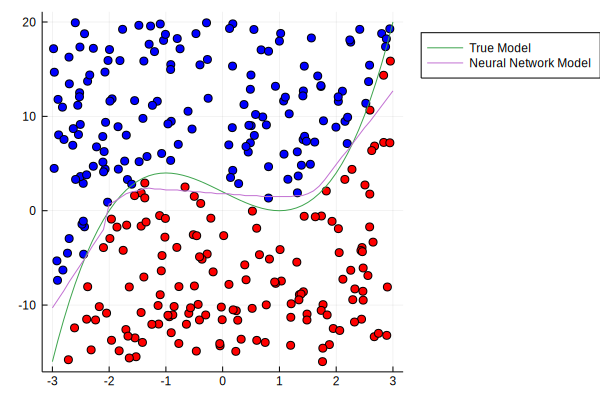

In [8]:
gif(anim)
plot_model(neural_model, x1grid, x2grid)